In [1]:
from functions_ver2 import data_pipeline as data_pipeline_v1
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, auc
import numpy as np
from itertools import product
from matplotlib import pyplot as plt


/workspaces/CS3244_ML_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# -----------------------------
# Neural Network - for One-Hot
# -----------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.2):
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1)) 
        self.network = nn.Sequential(*layers)
        
    
def forward(self, x):
        return self.network(x)

# -----------------------------
# Threshold tuning function
# -----------------------------
def tune_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_threshold, f1_scores[best_idx]


def train_mlp_cv(X, y, hp_dict, n_splits=5, random_state=42, model_type = 'onehot'):
    
    StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    
    fold_metrics = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X.values, y.values), 1):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
        
        loader_train = DataLoader(TensorDataset(X_train, y_train), 
                                batch_size=hp_dict["batch_size"], shuffle=True)
        loader_val = DataLoader(TensorDataset(X_val, y_val), 
                                batch_size=hp_dict["batch_size"])
        
        model = MLPClassifier(input_dim=X.shape[1], 
                            hidden_dims=hp_dict["hidden_dims"], 
                            dropout=hp_dict["dropout"]).to(device)
        
        
        pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.detach().clone().to(device))
        optimizer = torch.optim.Adam(model.parameters(), lr=hp_dict["lr"])
        
        # Training loop
        model.train()
        for epoch in range(hp_dict["n_epochs"]):
            for xb, yb in loader_train:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            y_val_logits = model(X_val.to(device))
            y_val_proba = torch.sigmoid(y_val_logits).cpu().numpy()
        
        best_threshold, best_f1 = tune_threshold(y_val.numpy(), y_val_proba)
        y_val_pred = (y_val_proba > best_threshold).astype(int)
        
        fold_metrics.append({
            "accuracy": accuracy_score(y_val.numpy(), y_val_pred),
            "f1": f1_score(y_val.numpy(), y_val_pred),
            "roc_auc": roc_auc_score(y_val.numpy(), y_val_proba),
            "best_threshold": best_threshold,
            "f1_at_threshold": best_f1
        })
        fold_models.append(model)
        
        print(f"Fold {fold}: Acc={fold_metrics[-1]['accuracy']:.3f}, "
              f"F1={fold_metrics[-1]['f1']:.3f}, ROC-AUC={fold_metrics[-1]['roc_auc']:.3f}, "
              f"Threshold={best_threshold:.2f}")
    
    # Select best model
    best_idx = np.argmax([m['roc_auc'] for m in fold_metrics])
    best_model = fold_models[best_idx]
    print(f"\nBest model: Fold {best_idx+1}, ROC-AUC={fold_metrics[best_idx]['roc_auc']:.3f}")
    
    return best_model, fold_metrics



## NNs 
- Can output vector from categorical variable embeddings instead of one-hot encoded --> more useful for model compared to one-hot

### Using One-Hot Encoding

In [11]:
X_train_std, y_train, X_train_smote_std, y_train_smote, X_train_smotetomek_std, y_train_smotetomek, X_train_cc_std, y_train_cc, X_test_std, y_test = data_pipeline_v1('onehot')

Loading data
Splitting data
Total unique accounts: 45985. Starting to find cutoff point
Cutoff month where CDF reaches 80%: -10

=== Split based on CDF 80% cutoff ===
Cutoff month: -10 (10 months ago)
Old accounts (≤ month -10): 37,210 (80.9%)
New accounts (> month -10): 8,775 (19.1%)
Ratio (old/new): 4.2405
Splitting raw credit records
Cleaning old accounts credit records - [Length: 996586]


/workspaces/CS3244_ML_Project/functions_ver2.py:243: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({


Cleaning new accounts credit records - [Length: 51989]


/workspaces/CS3244_ML_Project/functions_ver2.py:243: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({
/workspaces/CS3244_ML_Project/functions_ver2.py:171: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dropped=df_sorted.groupby('id', group_keys=False).apply(keep_row)
/workspaces/CS3244_ML_Project/functions_ver2.py:171: FutureWarning: DataFr

Cleaning credit data completed
Splitting application dataset
Cleaning old accounts application records - [Length: (29264, 18)]
Cleaning new accounts appplication records, - [Length: (7193, 18)]
Encoding
Encoders: {'name_income_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_education_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_family_status': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'name_housing_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False), 'occupation_type': OneHotEncoder(handle_unknown='ignore', sparse_output=False)}
Encoding type: onehot
Merging data
Engineering target variable to label data
Completed old accounts labelling
Completed new accounts labelling
Old accounts: (37210, 3)
New accounts: (8775, 3)
Old threshold: 0.20245245245245247
New threshold: 0.5786182336182336
Merging cleaned application and credit records
Train shape: (29264, 63)
Test shape: (7193, 63)
<class 'pandas.core.

In [ ]:
hp_dict = param_grid = {
    "hidden_dims": [[128,64], [256,128]],
    "dropout": [0.2, 0.3],
    "lr": [1e-3, 5e-4],
    "optimizer_name": ["adam", "sgd"],
    "activation_name": ["relu", "leaky_relu"]
}
best_model, metrics = train_mlp_cv(X_train_smote_std, y_train_smote, hp_dict)

In [ ]:
hp_dict = {
    "hidden_dims": [256, 128],
    "dropout": 0.3,
    "batch_size": 64,
    "lr": 5e-4,
    "n_epochs": 30
}
best_model, metrics = train_mlp_cv(X_train_smote_std, y_train_smote, hp_dict)

/tmp/ipykernel_2821/532990226.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))


Fold 1: Acc=0.699, F1=0.740, ROC-AUC=0.802, Threshold=0.41


/tmp/ipykernel_2821/532990226.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))


Fold 2: Acc=0.712, F1=0.743, ROC-AUC=0.808, Threshold=0.45


/tmp/ipykernel_2821/532990226.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))


Fold 3: Acc=0.706, F1=0.743, ROC-AUC=0.804, Threshold=0.33


/tmp/ipykernel_2821/532990226.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))


Fold 4: Acc=0.697, F1=0.739, ROC-AUC=0.804, Threshold=0.40


/tmp/ipykernel_2821/532990226.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))


Fold 5: Acc=0.712, F1=0.742, ROC-AUC=0.807, Threshold=0.40

Best model: Fold 2, ROC-AUC=0.808


### Using Lable Encoding

In [2]:
X_train_std_cat, y_train_cat, X_train_smote_std_cat, y_train_cat_smote, X_train_smotetomek_std_cat, y_train_cat_smotetomek, X_train_cc_std_cat, y_train_cat_cc, X_test_std_cat, y_test = data_pipeline_v1('label')

Loading data
Splitting data
Total unique accounts: 45985. Starting to find cutoff point
Cutoff month where CDF reaches 80%: -10

=== Split based on CDF 80% cutoff ===
Cutoff month: -10 (10 months ago)
Old accounts (≤ month -10): 37,210 (80.9%)
New accounts (> month -10): 8,775 (19.1%)
Ratio (old/new): 4.2405
Splitting raw credit records
Cleaning old accounts credit records - [Length: 996586]


/workspaces/CS3244_ML_Project/functions_ver2.py:235: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({


Cleaning new accounts credit records - [Length: 51989]


/workspaces/CS3244_ML_Project/functions_ver2.py:235: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df.groupby(['id', 'origination_month']).apply(lambda x: pd.Series({
/workspaces/CS3244_ML_Project/functions_ver2.py:161: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dropped=df_sorted.groupby('id', group_keys=False).apply(keep_row)
/workspaces/CS3244_ML_Project/functions_ver2.py:161: FutureWarning: DataFr

Cleaning credit data completed
Splitting application dataset
Cleaning old accounts application records - [Length: (29264, 18)]
Cleaning new accounts appplication records, - [Length: (7193, 18)]
Encoding
Encoders: {'name_income_type': LabelEncoder(), 'name_education_type': LabelEncoder(), 'name_family_status': LabelEncoder(), 'name_housing_type': LabelEncoder(), 'occupation_type': LabelEncoder()}
Encoding type: label
Merging data
Engineering target variable to label data
Completed old accounts labelling
Completed new accounts labelling
Old accounts: (37210, 3)
New accounts: (8775, 3)
Old threshold: 0.20157657657657657
New threshold: 0.5786182336182336
Merging cleaned application and credit records
Train shape: (29264, 28)
Test shape: (7193, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29264 entries, 0 to 29263
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id              

In [ ]:
# -----------------------------
# Activation mapping
# -----------------------------
activation_map = {
    "relu": nn.ReLU(),
    "leaky_relu": nn.LeakyReLU(),
    "tanh": nn.Tanh()
}

# -----------------------------
# Neural Network with Embeddings
# -----------------------------
class MLPWithEmbeddings(nn.Module):
    def __init__(self, n_numeric, cat_cardinalities, emb_dims, hidden_dims=[128,64], dropout=0.2, activation="relu"):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(card, dim) for card, dim in zip(cat_cardinalities, emb_dims)])
        total_emb_dim = sum(emb_dims)
        input_dim = n_numeric + total_emb_dim

        # Dense layers
        layers = []
        act_layer = activation_map[activation]
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(act_layer)
            layers.append(nn.Dropout(dropout))
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x_num, x_cat):
        emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x = torch.cat([x_num] + emb, dim=1)
        return self.network(x)

# -----------------------------
# Threshold tuning function
# -----------------------------
def tune_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return best_threshold, f1_scores[best_idx]

# -----------------------------
# Training with CV (supports hyperparameters)
# -----------------------------
def train_mlp_cv_embeddings(X_num, X_cat, y, cat_cardinalities, emb_dims,
                            hidden_dims=[128,64], dropout=0.2, lr=1e-3,
                            optimizer_name="adam", activation_name="relu",
                            n_splits=5, n_epochs=30, random_state=42):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    X_num_tensor = torch.tensor(X_num.values, dtype=torch.float32)
    X_cat_tensor = torch.tensor(X_cat.values, dtype=torch.long)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    fold_metrics = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_num.values, y.values), 1):
        X_num_train, X_num_val = X_num_tensor[train_idx], X_num_tensor[val_idx]
        X_cat_train, X_cat_val = X_cat_tensor[train_idx], X_cat_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        loader_train = DataLoader(TensorDataset(X_num_train, X_cat_train, y_train),
                                  batch_size=64, shuffle=True)
        loader_val = DataLoader(TensorDataset(X_num_val, X_cat_val, y_val),
                                batch_size=64)

        model = MLPWithEmbeddings(
            n_numeric=X_num.shape[1],
            cat_cardinalities=cat_cardinalities,
            emb_dims=emb_dims,
            hidden_dims=hidden_dims,
            dropout=dropout,
            activation=activation_name
        ).to(device)

        # Handle class imbalance
        pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.detach().clone().to(device))

        # Optimizer selection
        if optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        # Training loop
        model.train()
        for epoch in range(n_epochs):
            for xb_num, xb_cat, yb in loader_train:
                xb_num, xb_cat, yb = xb_num.to(device), xb_cat.to(device), yb.to(device)
                optimizer.zero_grad()
                pred = model(xb_num, xb_cat)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_logits = model(X_num_val.to(device), X_cat_val.to(device))
            y_val_proba = torch.sigmoid(y_val_logits).cpu().numpy()

        best_threshold, best_f1 = tune_threshold(y_val.numpy(), y_val_proba)
        y_val_pred = (y_val_proba > best_threshold).astype(int)

        precision_vals, recall_vals, thresholds = precision_recall_curve(y_val.numpy(), y_val_proba)
        pr_auc = auc(recall_vals, precision_vals)
        fold_metrics.append({
            "pr_auc": pr_auc,                  
            "precision_vals": precision_vals,  
            "recall_vals": recall_vals,        
            "thresholds": thresholds,          
            "f1": f1_score(y_val.numpy(), y_val_pred),
            "roc_auc": roc_auc_score(y_val.numpy(), y_val_proba),
            "best_threshold": best_threshold,
            "f1_at_threshold": best_f1
        })
        fold_models.append(model)

    best_idx = np.argmax([m['f1'] for m in fold_metrics])
    best_model = fold_models[best_idx]
    best_metrics = fold_metrics[best_idx]

    print("=== Best Model Metrics ===")
    print(f"F1 score at best threshold: {best_metrics['f1_at_threshold']:.3f}")
    print(f"ROC-AUC: {best_metrics['roc_auc']:.3f}")
    print(f"PR-AUC: {best_metrics['pr_auc']:.3f}")
    print(f"Best threshold: {best_metrics['best_threshold']:.2f}")
    print(f"Hyperparameters: hidden_dims={hidden_dims}, dropout={dropout}, lr={lr}, optimizer={optimizer_name}, activation={activation_name}")

   
    # Identify best fold (already selected via your criterion, e.g., highest F1 or ROC-AUC)
    best_fold_idx = np.argmax([m['f1_at_threshold'] for m in fold_metrics])
    best_fold = fold_metrics[best_fold_idx]

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- Left: Fold-wise PR curves ---
    for i, m in enumerate(fold_metrics):
        alpha = 0.3 if i != best_fold_idx else 1.0  
        lw = 1 if i != best_fold_idx else 3
        label = f"Fold {i+1}" if i != best_fold_idx else f"Best Fold {i+1} (PR-AUC={m['pr_auc']:.3f})"
        axes[0].plot(m['recall_vals'], m['precision_vals'], alpha=alpha, lw=lw, label=label)

    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision-Recall Curves Across Folds")
    axes[0].legend()
    axes[0].grid(True)

    precision_trim = best_fold['precision_vals'][:-1]
    recall_trim = best_fold['recall_vals'][:-1]
    f1_scores_fold = 2 * precision_trim * recall_trim / (precision_trim + recall_trim + 1e-6)

    axes[1].plot(best_fold['thresholds'], f1_scores_fold, lw=2, label='F1 Score')
    axes[1].axvline(best_fold['best_threshold'], color='red', linestyle='--',
                    label=f"Best Threshold = {best_fold['best_threshold']:.2f}")
    axes[1].set_xlabel("Threshold")
    axes[1].set_ylabel("F1 Score")
    axes[1].set_title("F1 Score vs Threshold (Best Fold)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return best_model, best_metrics, fold_metrics



=== Best Model Metrics ===
F1 score at best threshold: 0.706
ROC-AUC: 0.741
PR-AUC: 0.761
Best threshold: 0.38
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.001, optimizer=adam, activation=relu


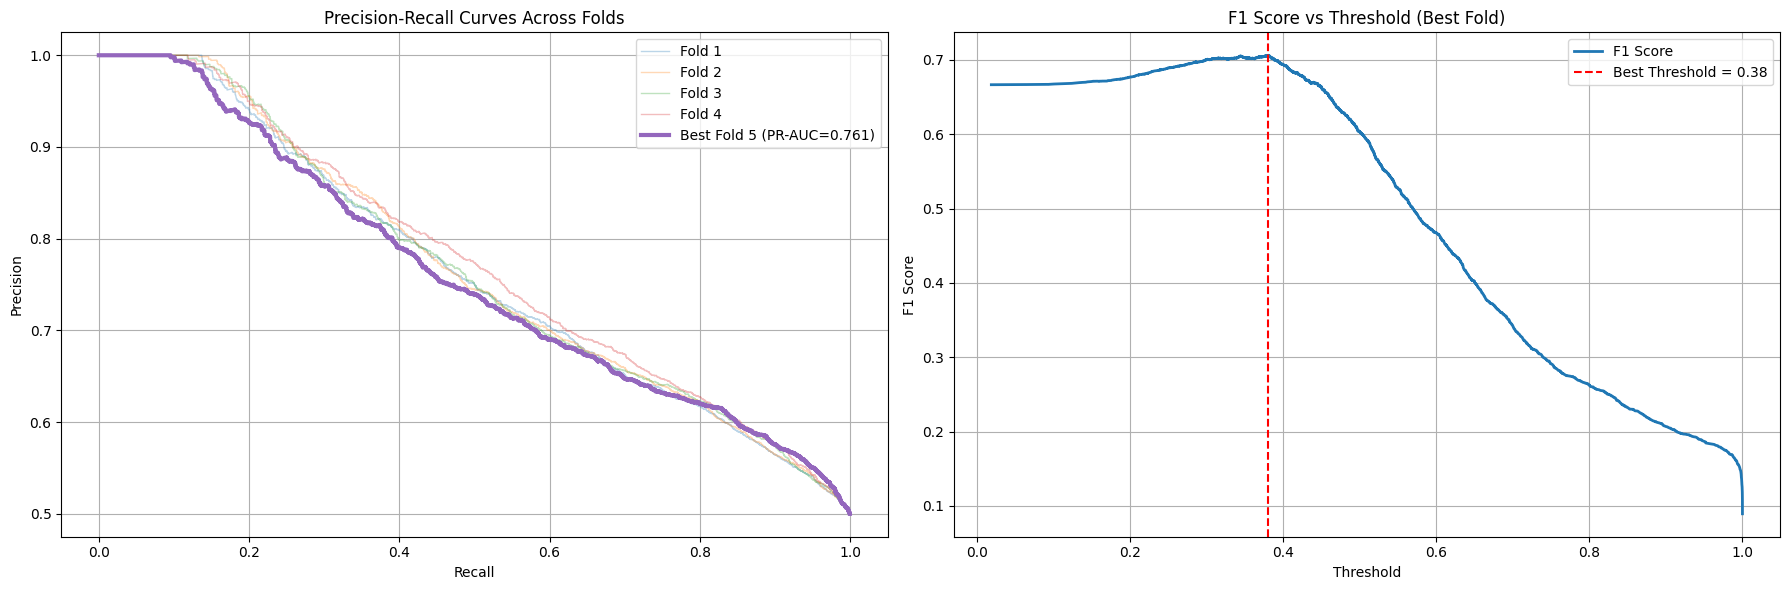

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.710
ROC-AUC: 0.749
PR-AUC: 0.771
Best threshold: 0.30
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.001, optimizer=adam, activation=leaky_relu


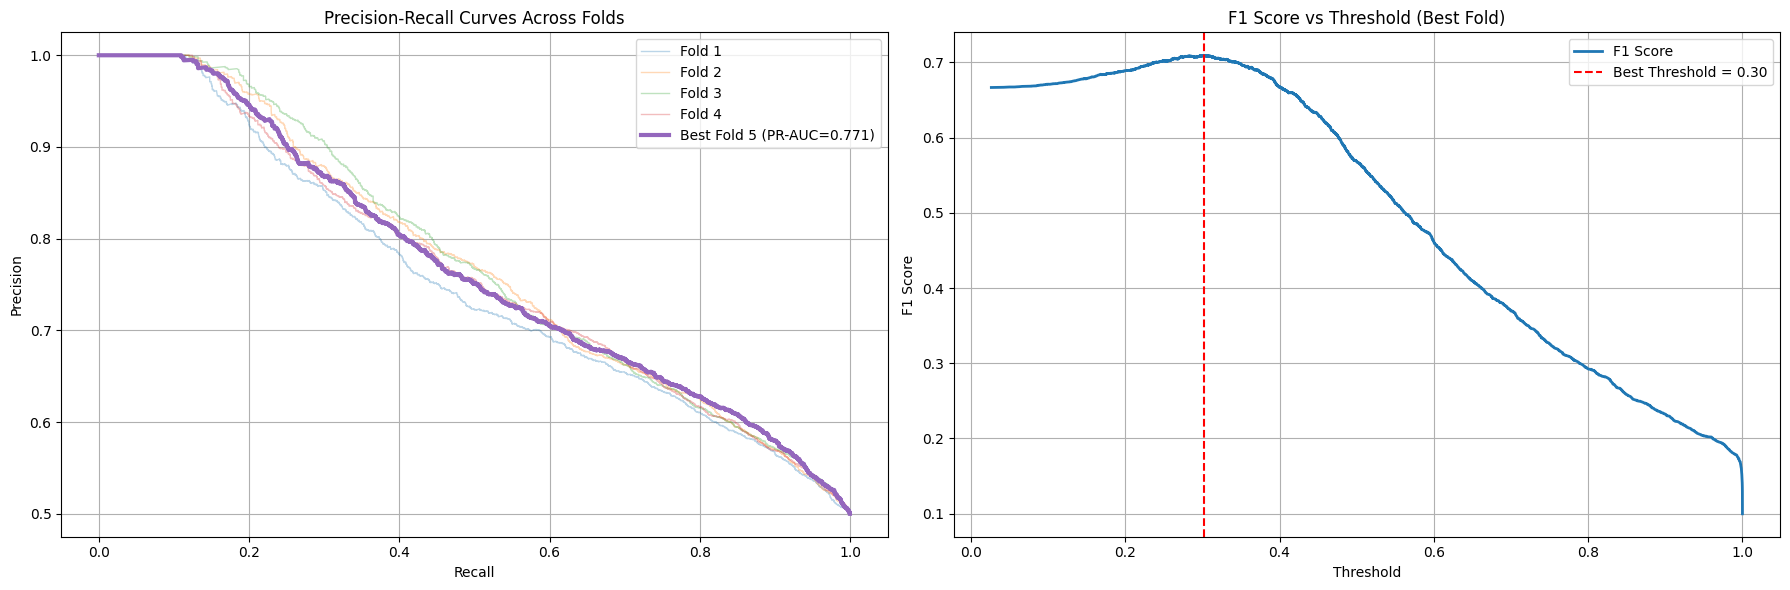

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.547
PR-AUC: 0.556
Best threshold: 0.48
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.001, optimizer=sgd, activation=relu


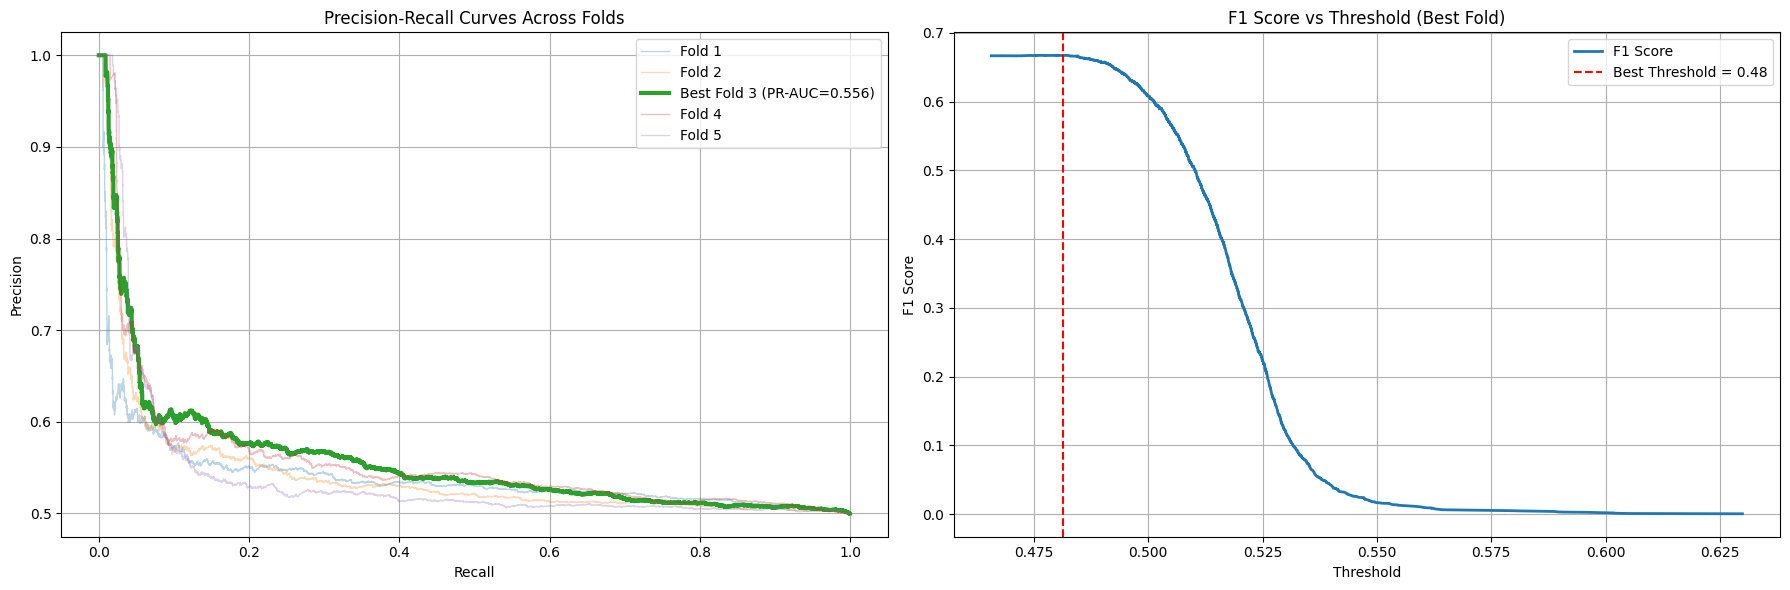

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.531
PR-AUC: 0.522
Best threshold: 0.48
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.001, optimizer=sgd, activation=leaky_relu


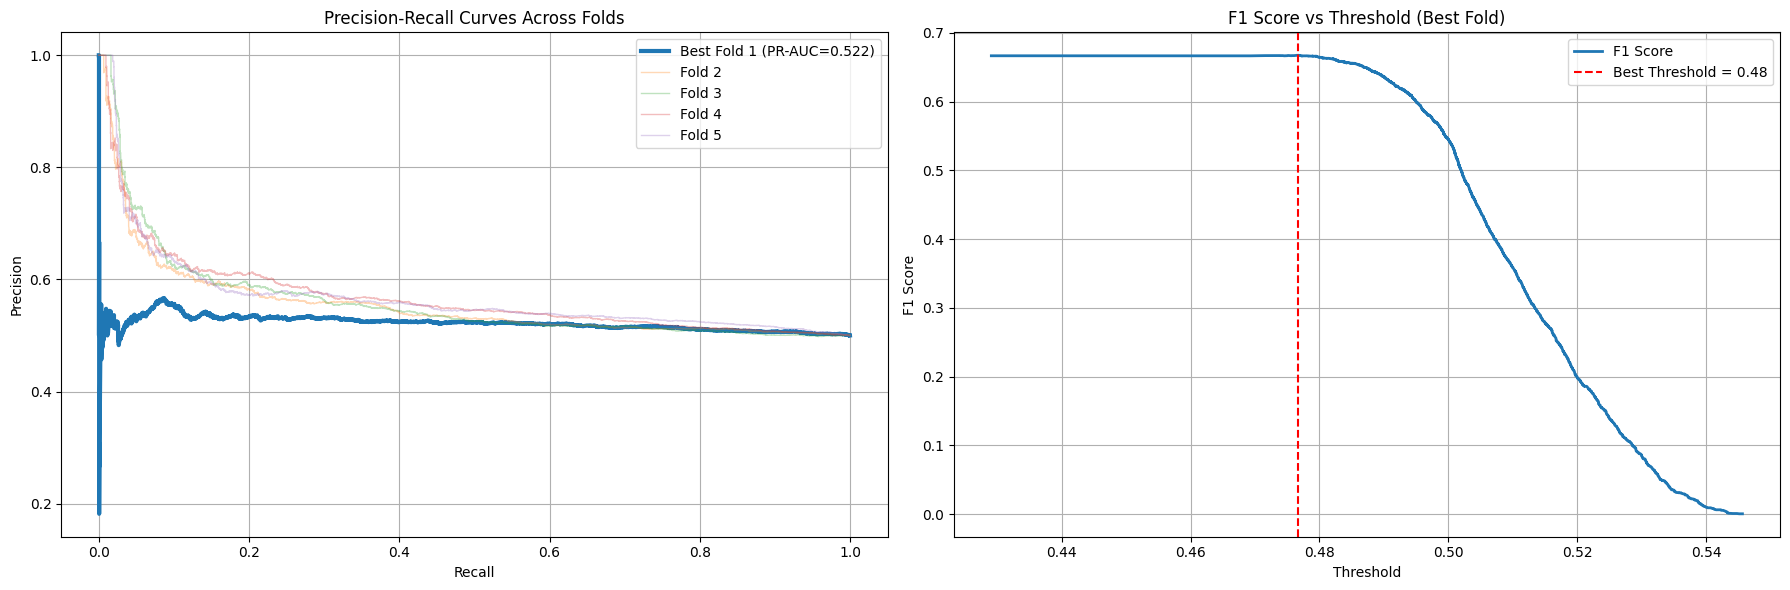

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.702
ROC-AUC: 0.732
PR-AUC: 0.751
Best threshold: 0.33
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.0005, optimizer=adam, activation=relu


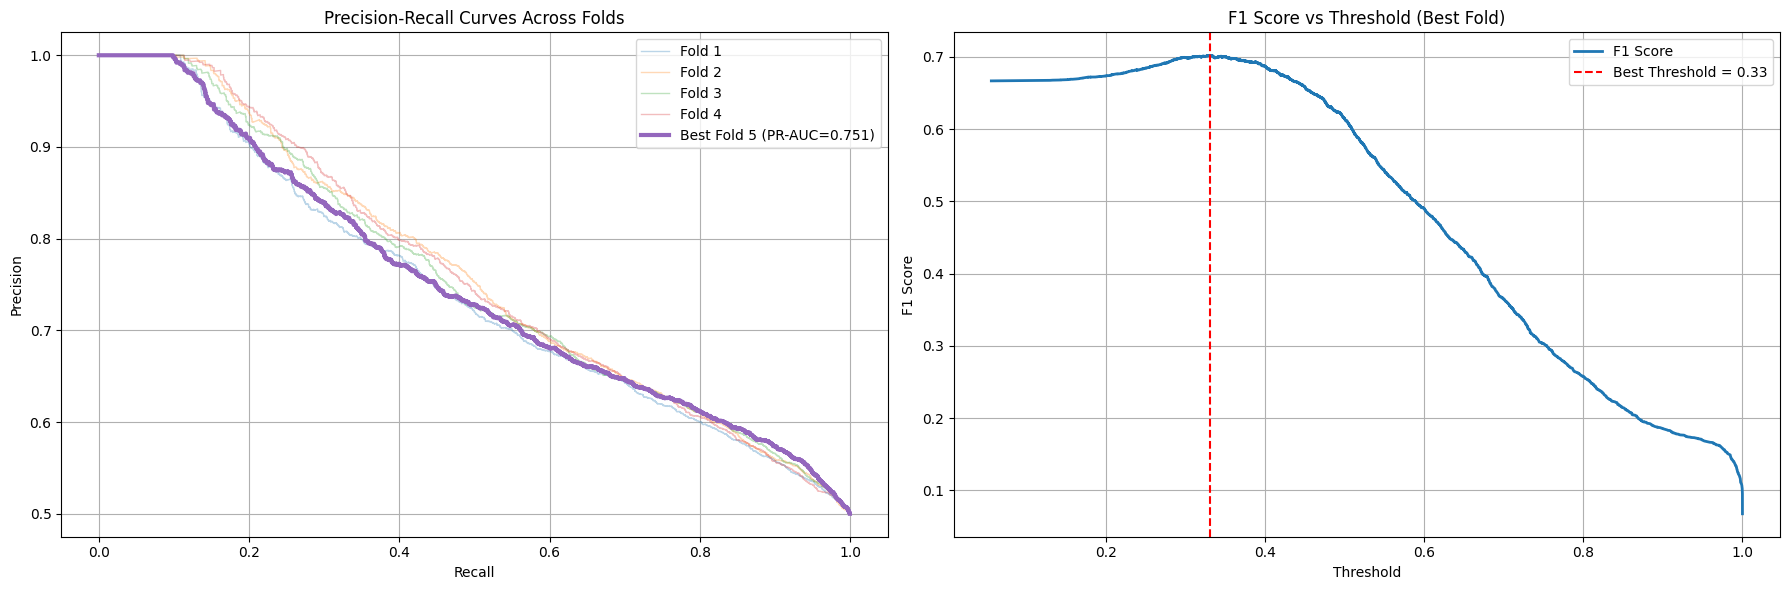

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.700
ROC-AUC: 0.729
PR-AUC: 0.750
Best threshold: 0.35
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.0005, optimizer=adam, activation=leaky_relu


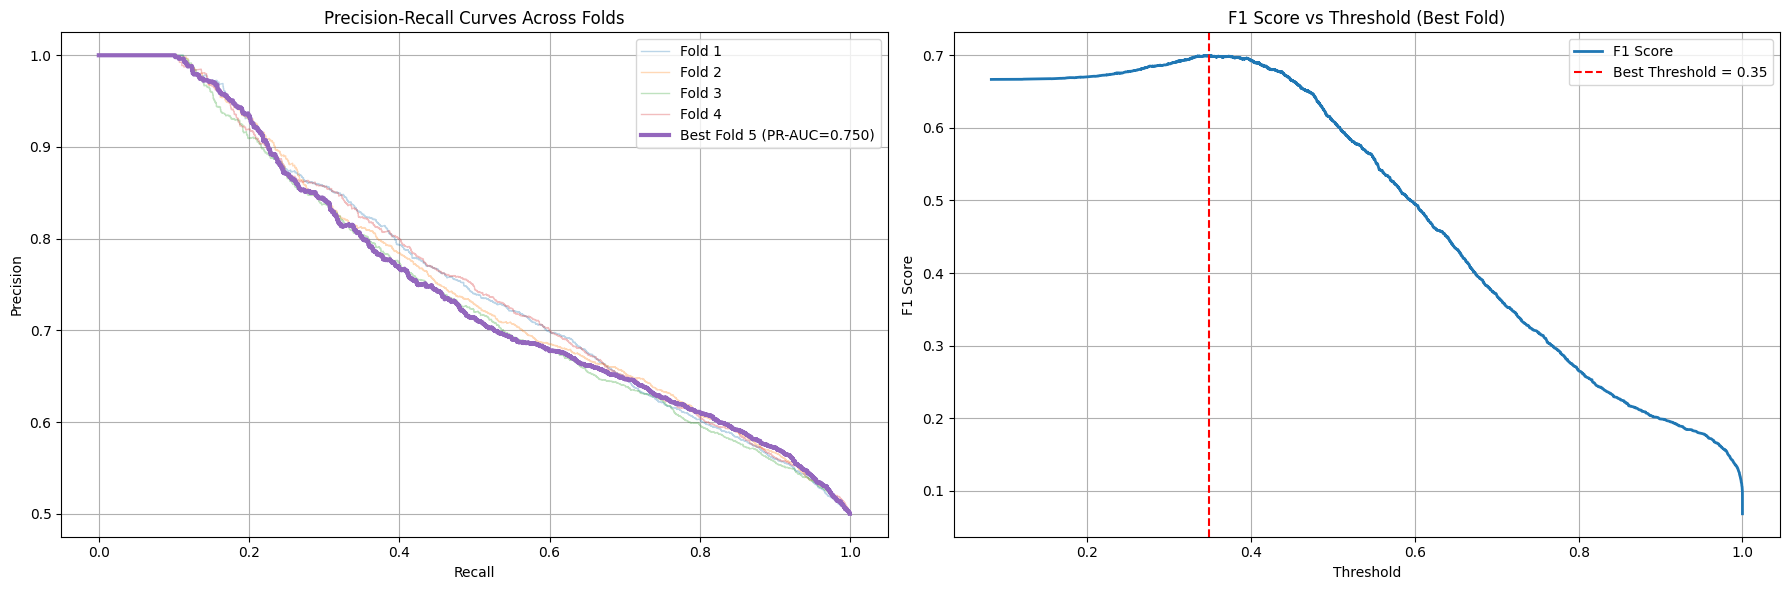

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.668
ROC-AUC: 0.540
PR-AUC: 0.554
Best threshold: 0.46
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.0005, optimizer=sgd, activation=relu


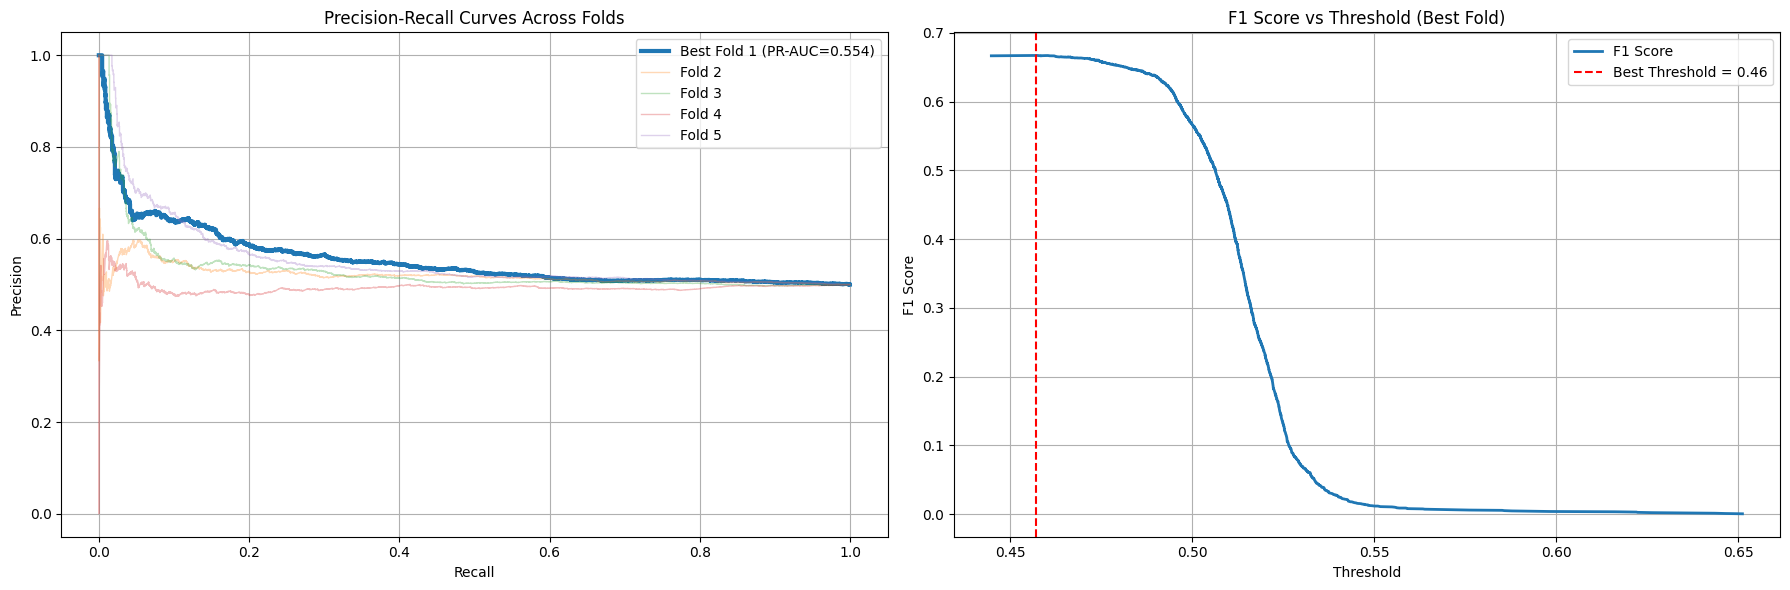

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.502
PR-AUC: 0.521
Best threshold: 0.46
Hyperparameters: hidden_dims=[128, 64], dropout=0.2, lr=0.0005, optimizer=sgd, activation=leaky_relu


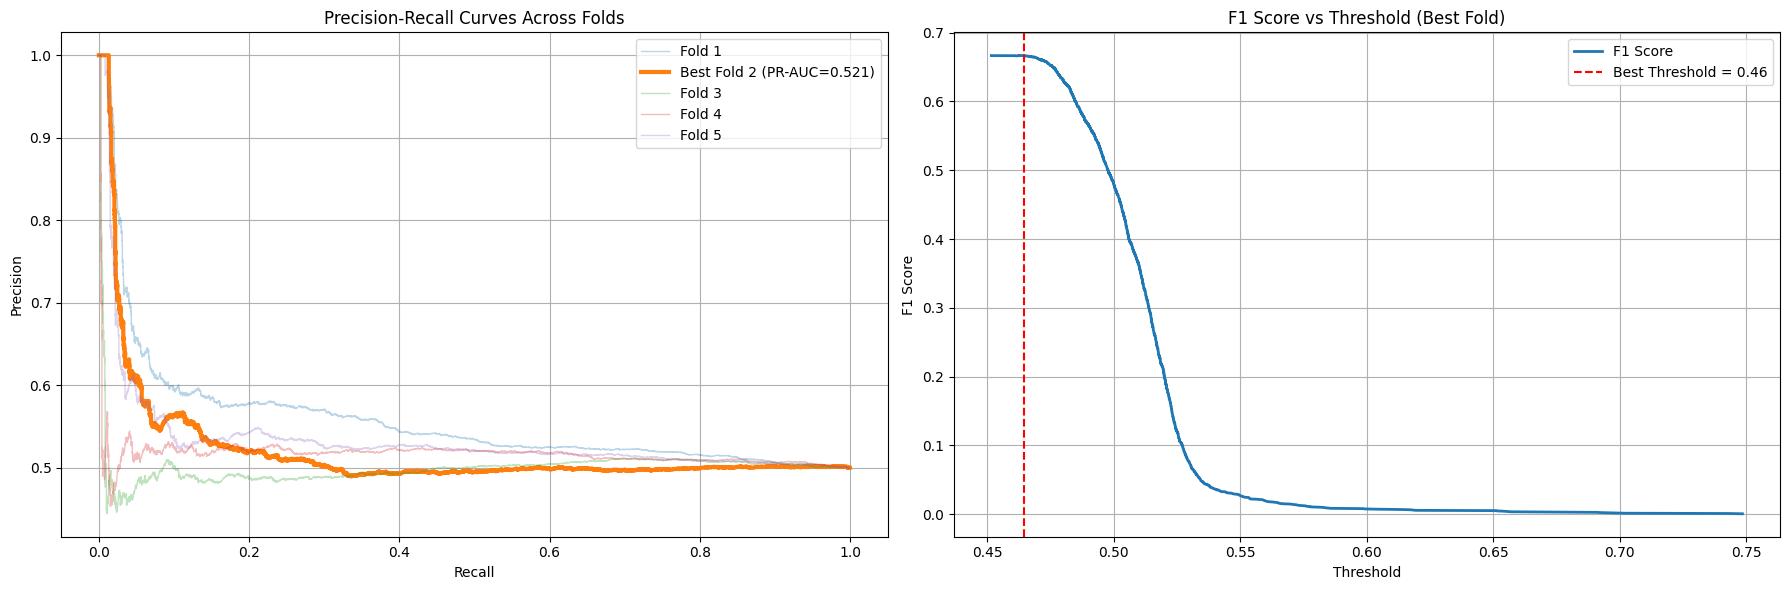

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.703
ROC-AUC: 0.744
PR-AUC: 0.769
Best threshold: 0.37
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.001, optimizer=adam, activation=relu


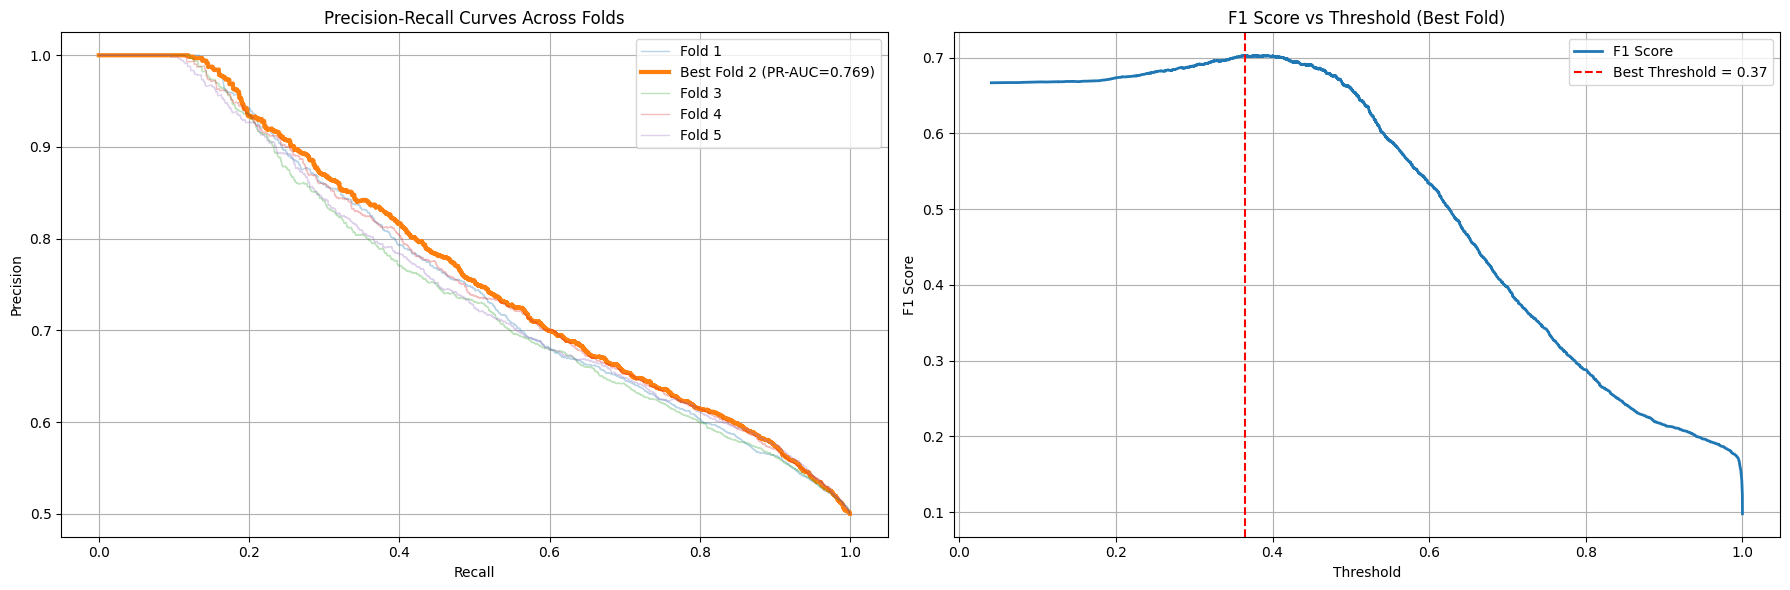

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.702
ROC-AUC: 0.740
PR-AUC: 0.763
Best threshold: 0.39
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.001, optimizer=adam, activation=leaky_relu


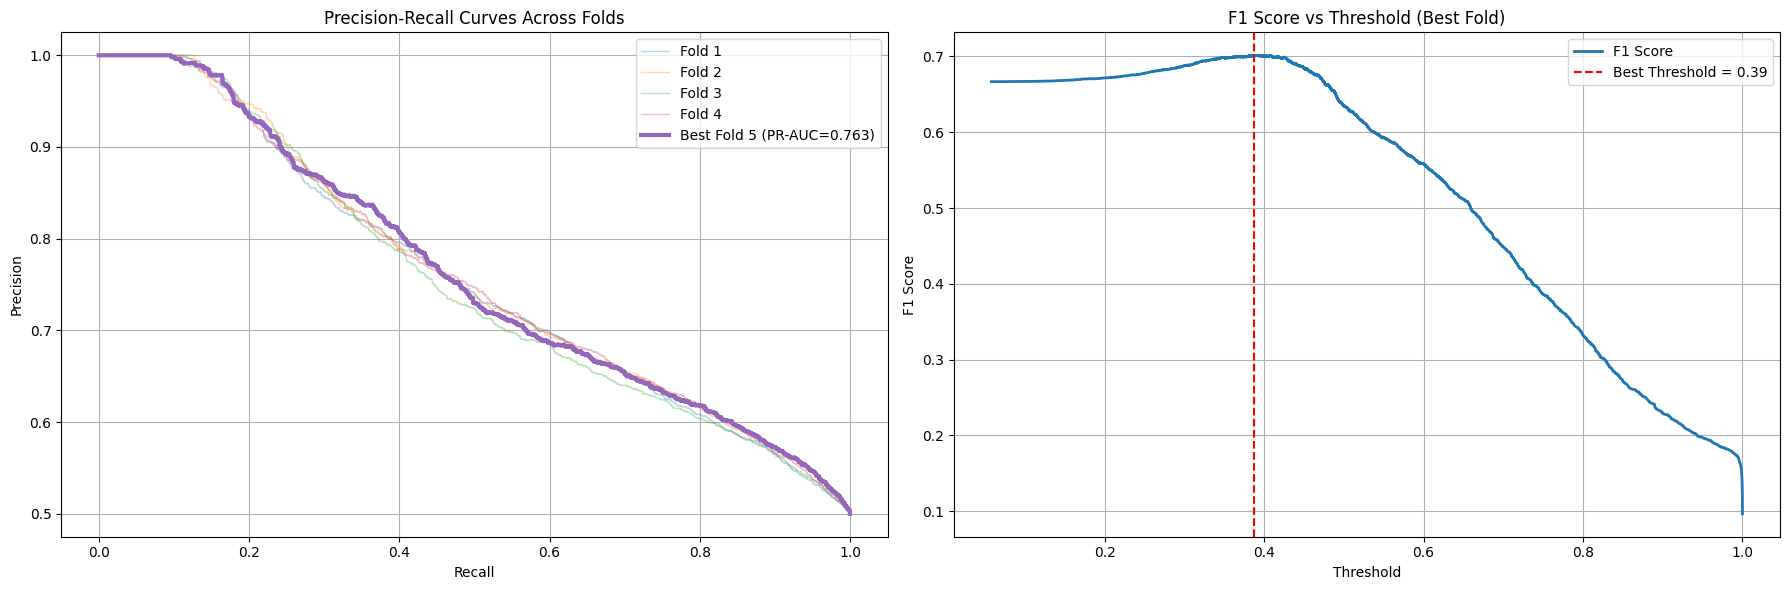

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.567
PR-AUC: 0.578
Best threshold: 0.47
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.001, optimizer=sgd, activation=relu


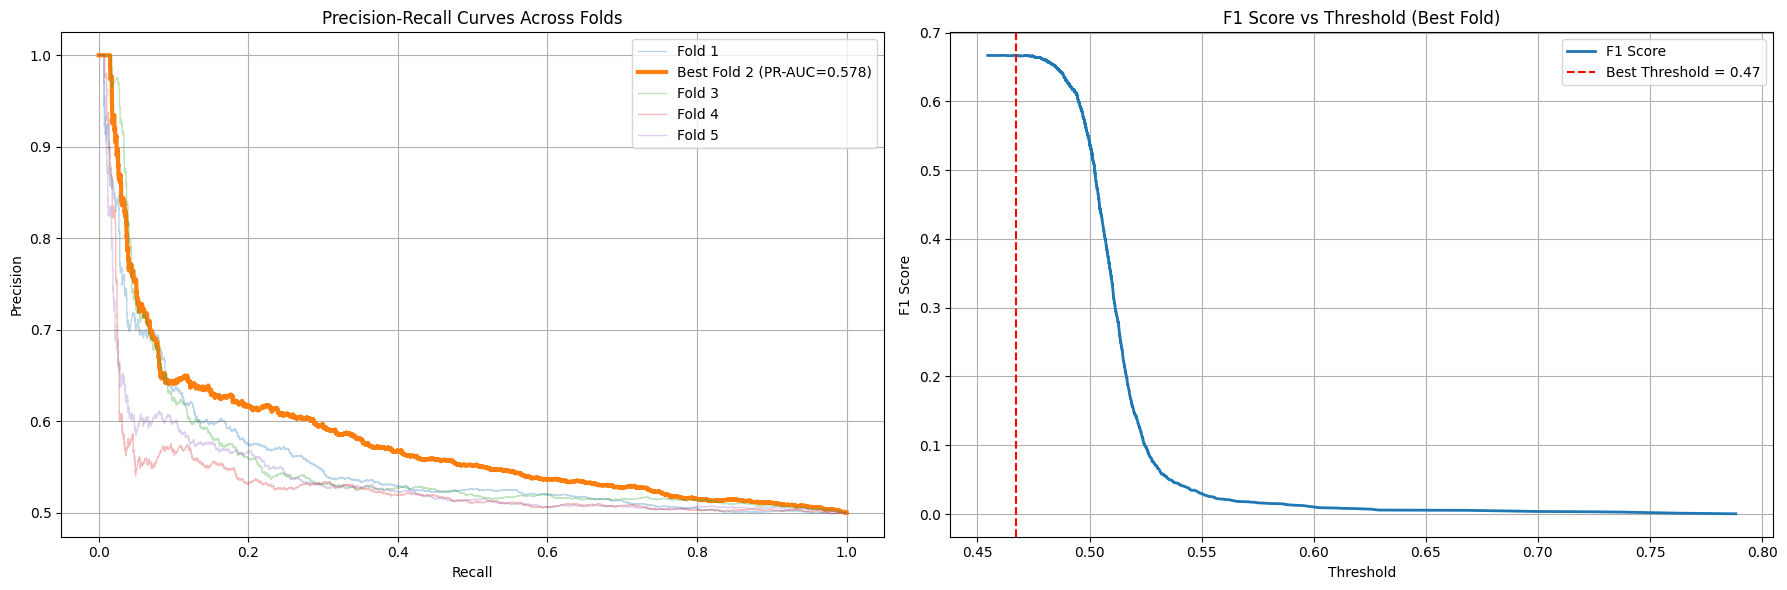

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.550
PR-AUC: 0.569
Best threshold: 0.47
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.001, optimizer=sgd, activation=leaky_relu


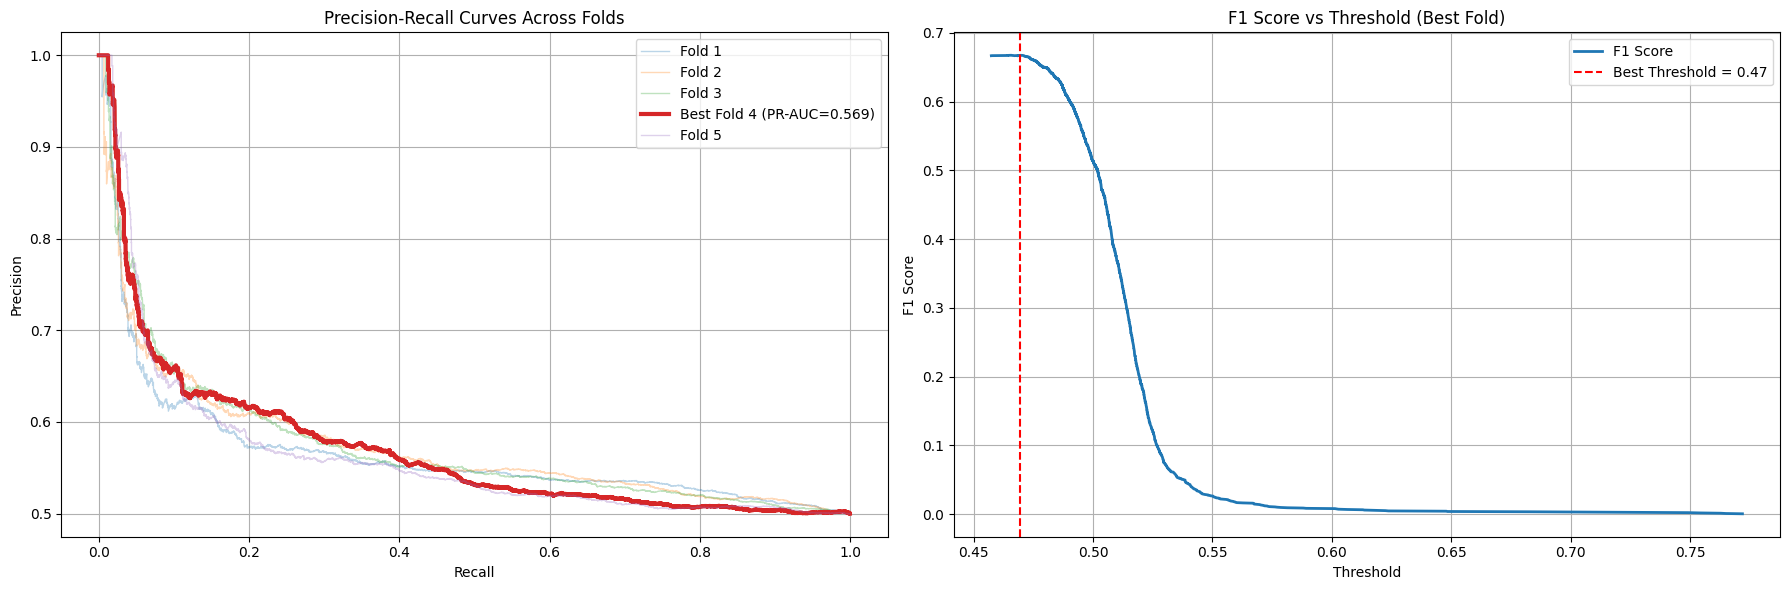

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.695
ROC-AUC: 0.718
PR-AUC: 0.740
Best threshold: 0.34
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.0005, optimizer=adam, activation=relu


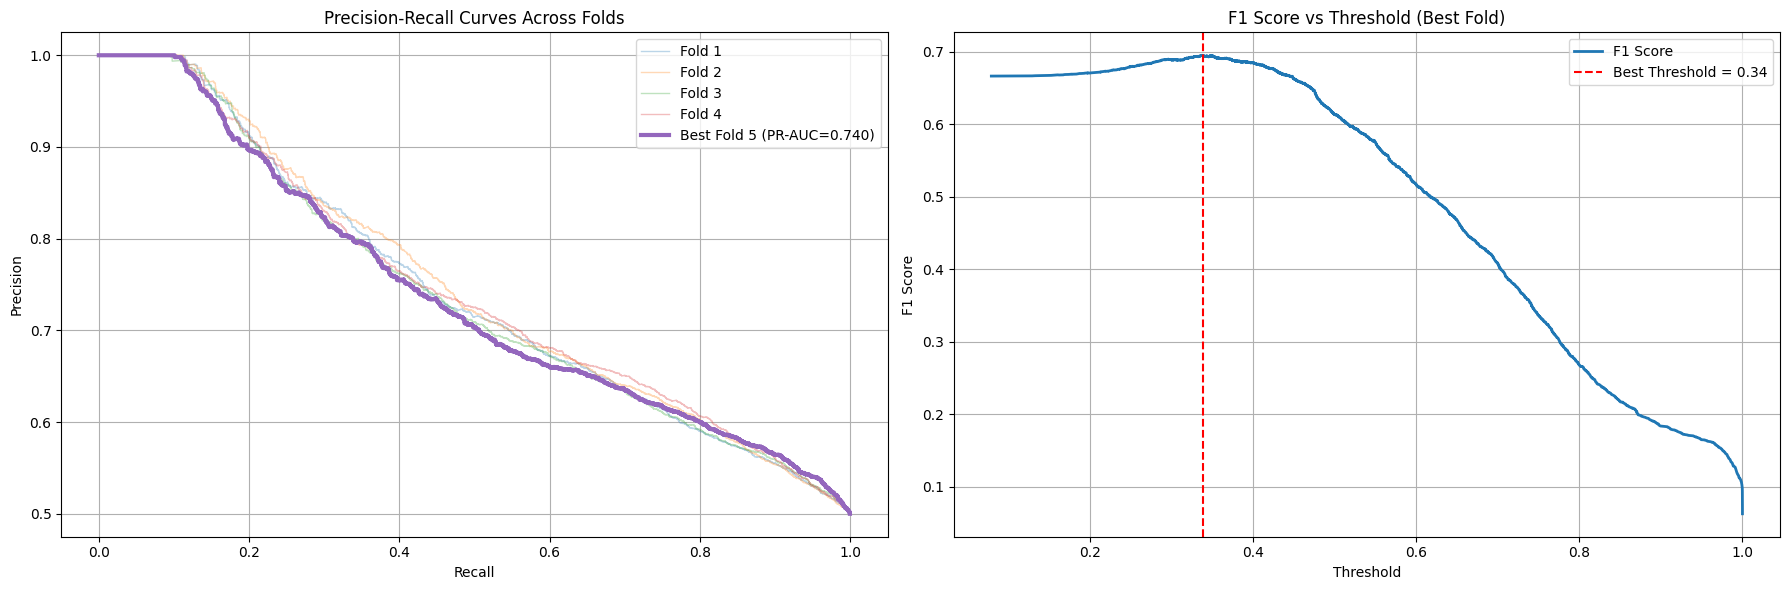

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.696
ROC-AUC: 0.720
PR-AUC: 0.743
Best threshold: 0.32
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.0005, optimizer=adam, activation=leaky_relu


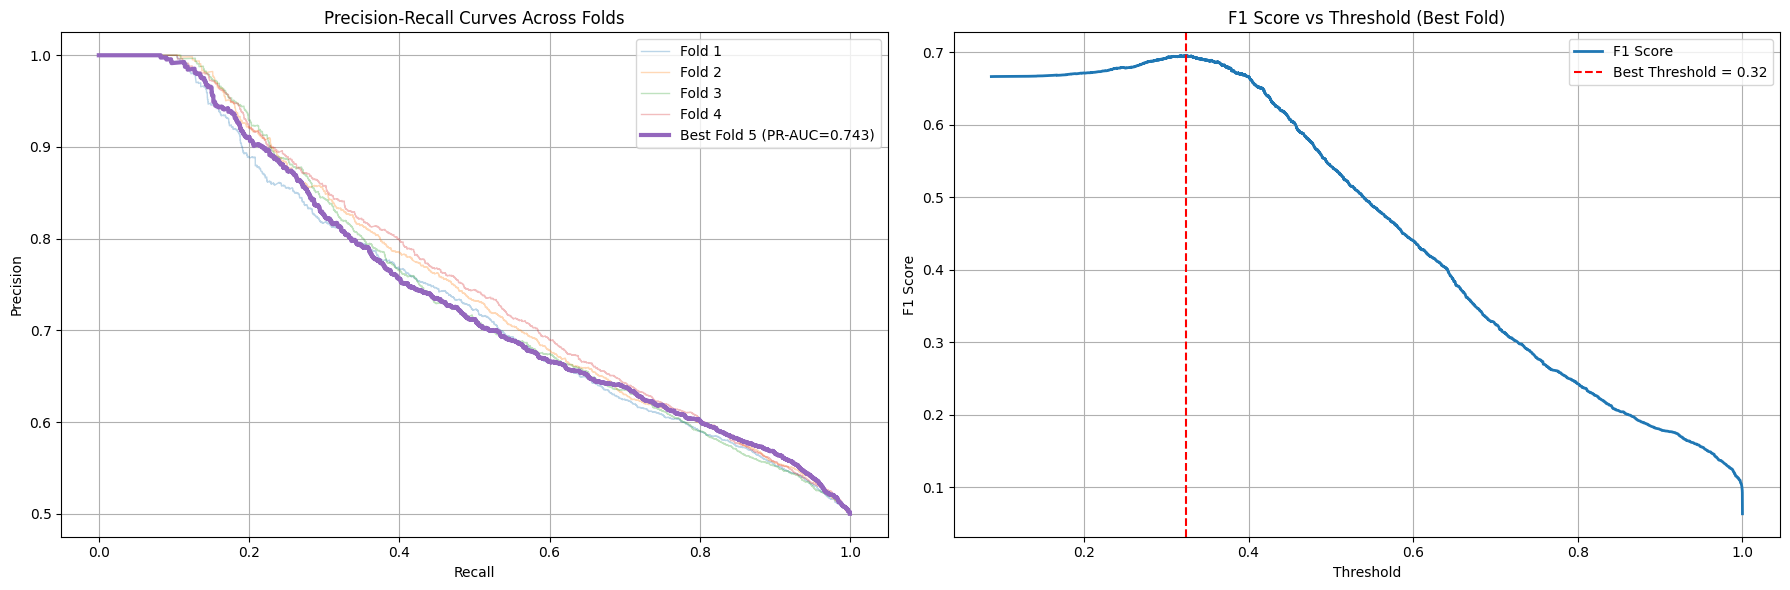

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.515
PR-AUC: 0.539
Best threshold: 0.46
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.0005, optimizer=sgd, activation=relu


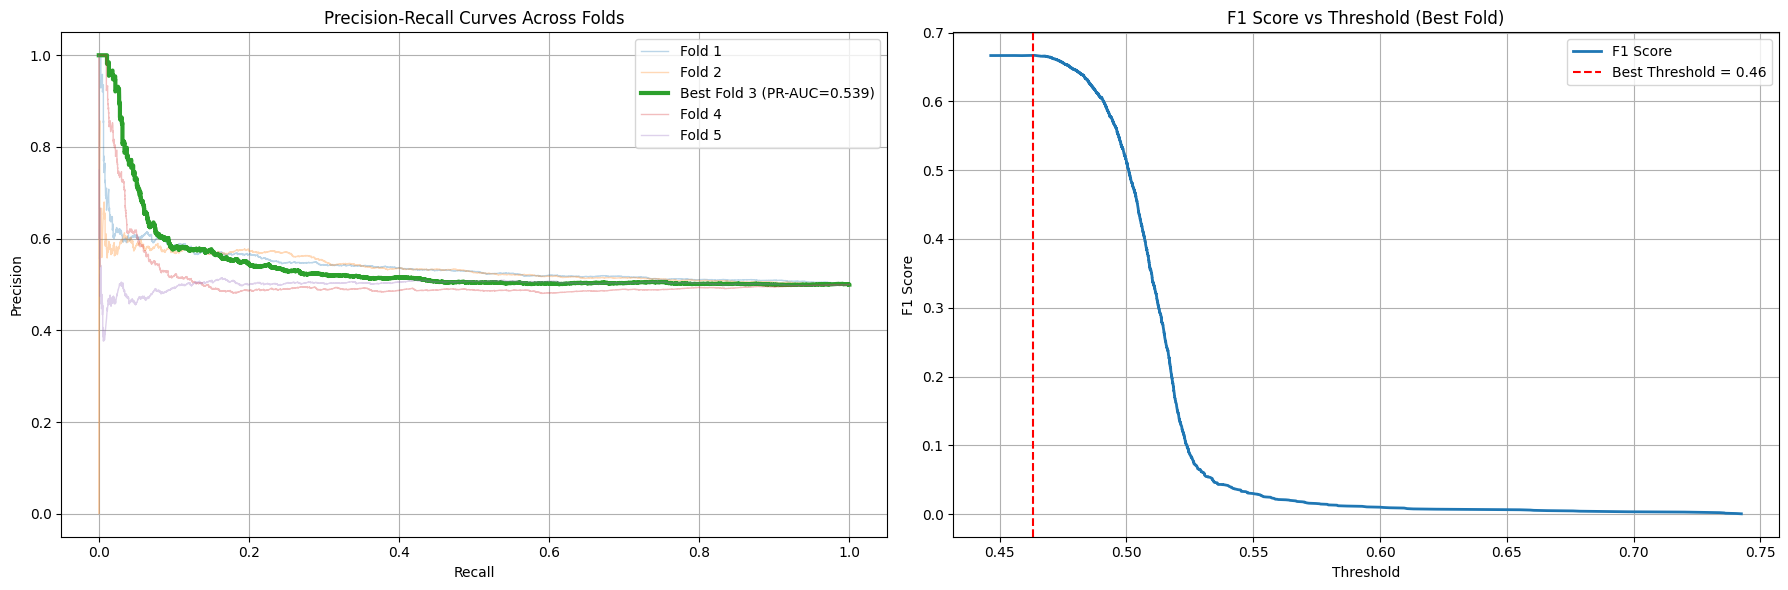

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.668
ROC-AUC: 0.539
PR-AUC: 0.545
Best threshold: 0.47
Hyperparameters: hidden_dims=[128, 64], dropout=0.3, lr=0.0005, optimizer=sgd, activation=leaky_relu


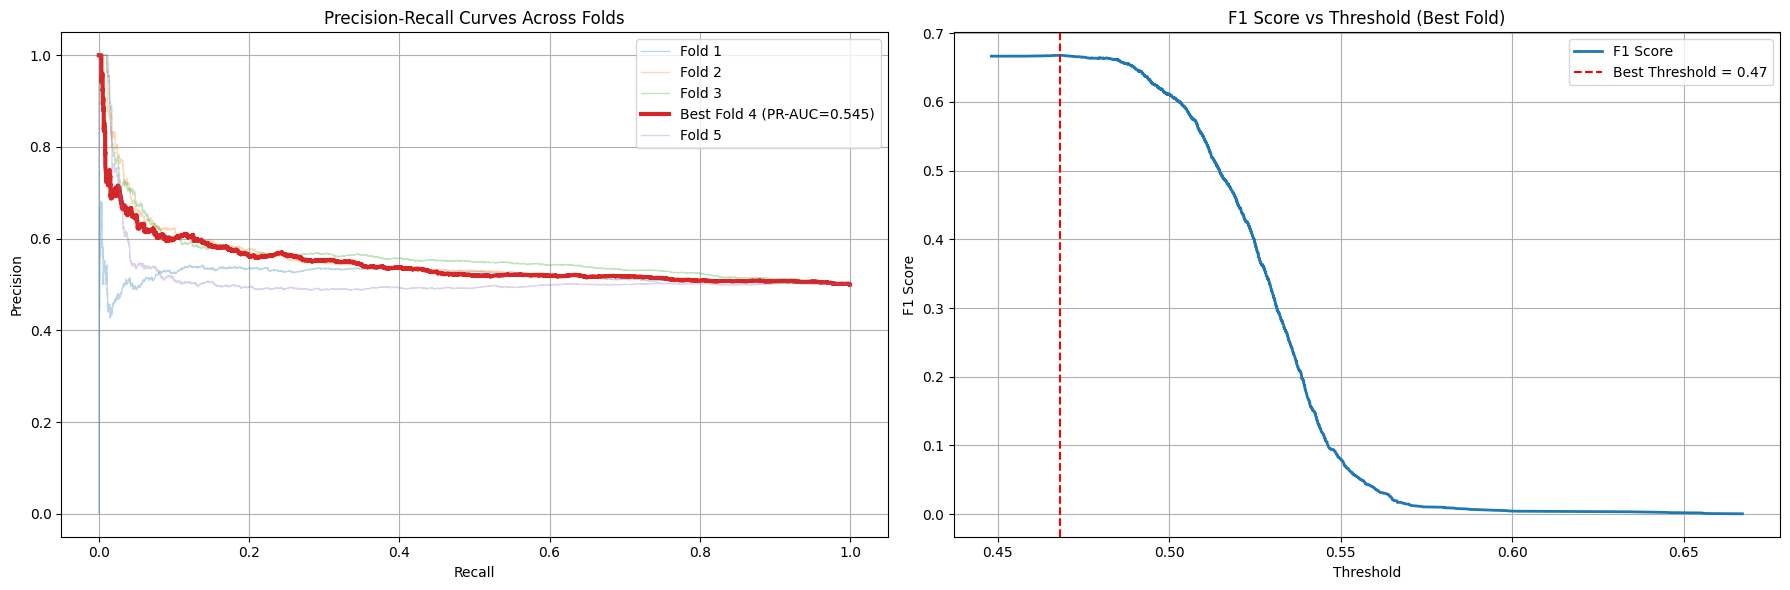

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.713
ROC-AUC: 0.769
PR-AUC: 0.794
Best threshold: 0.42
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.001, optimizer=adam, activation=relu


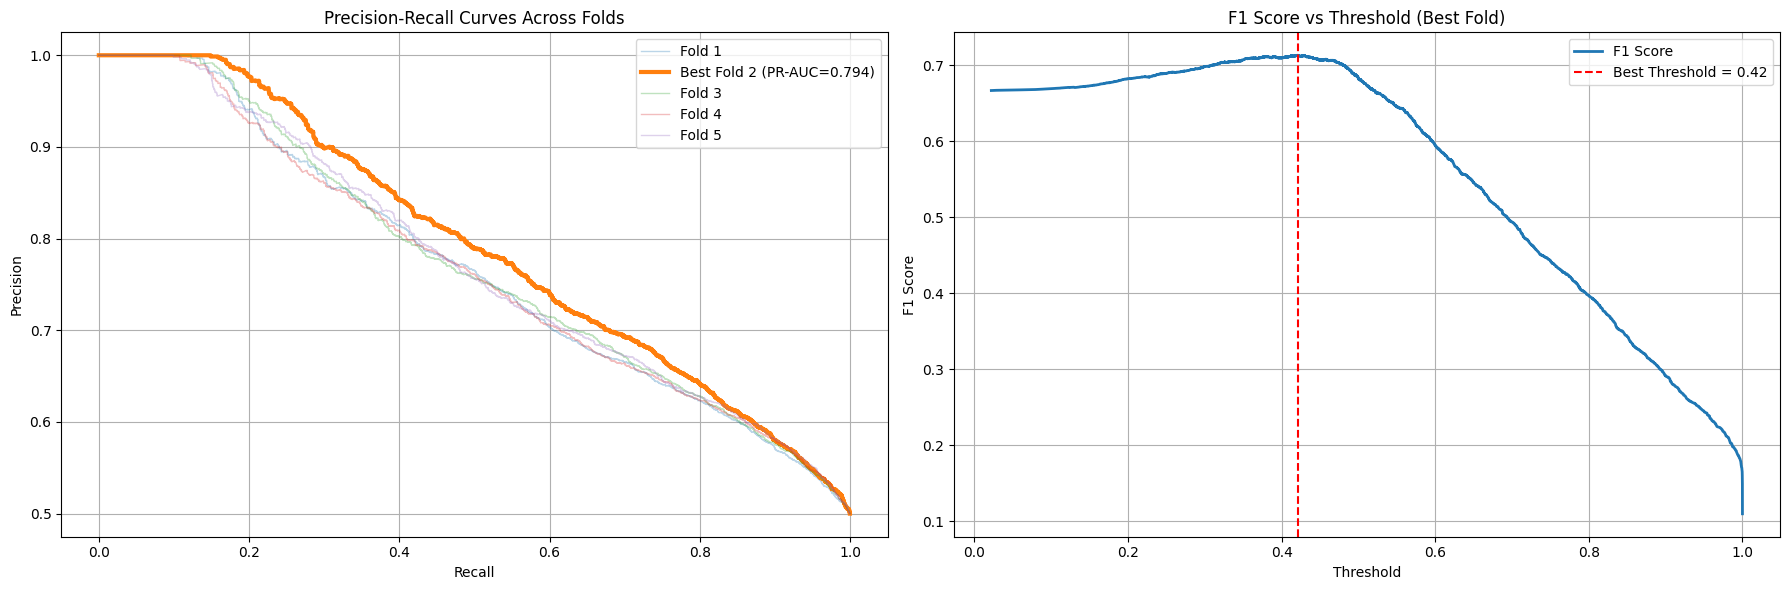

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.716
ROC-AUC: 0.760
PR-AUC: 0.781
Best threshold: 0.38
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.001, optimizer=adam, activation=leaky_relu


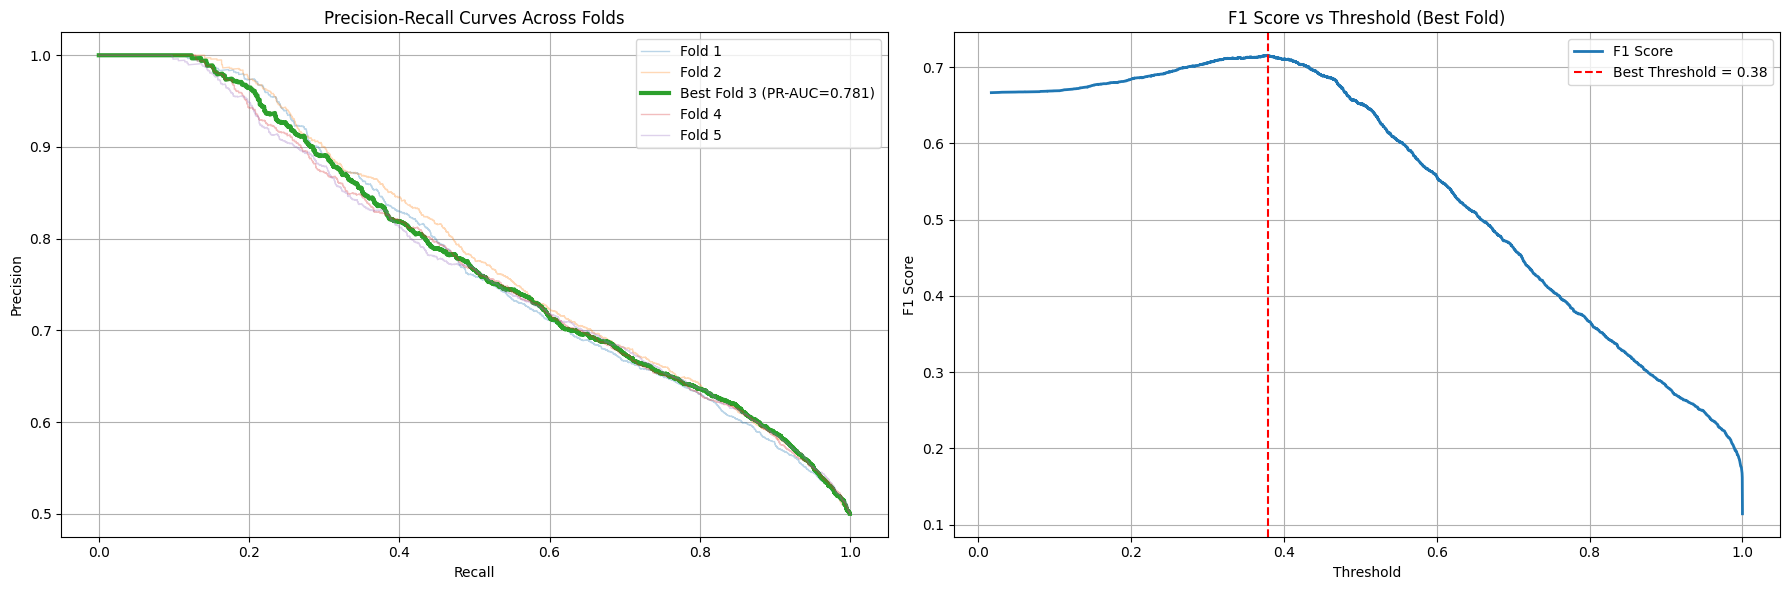

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.668
ROC-AUC: 0.571
PR-AUC: 0.581
Best threshold: 0.46
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.001, optimizer=sgd, activation=relu


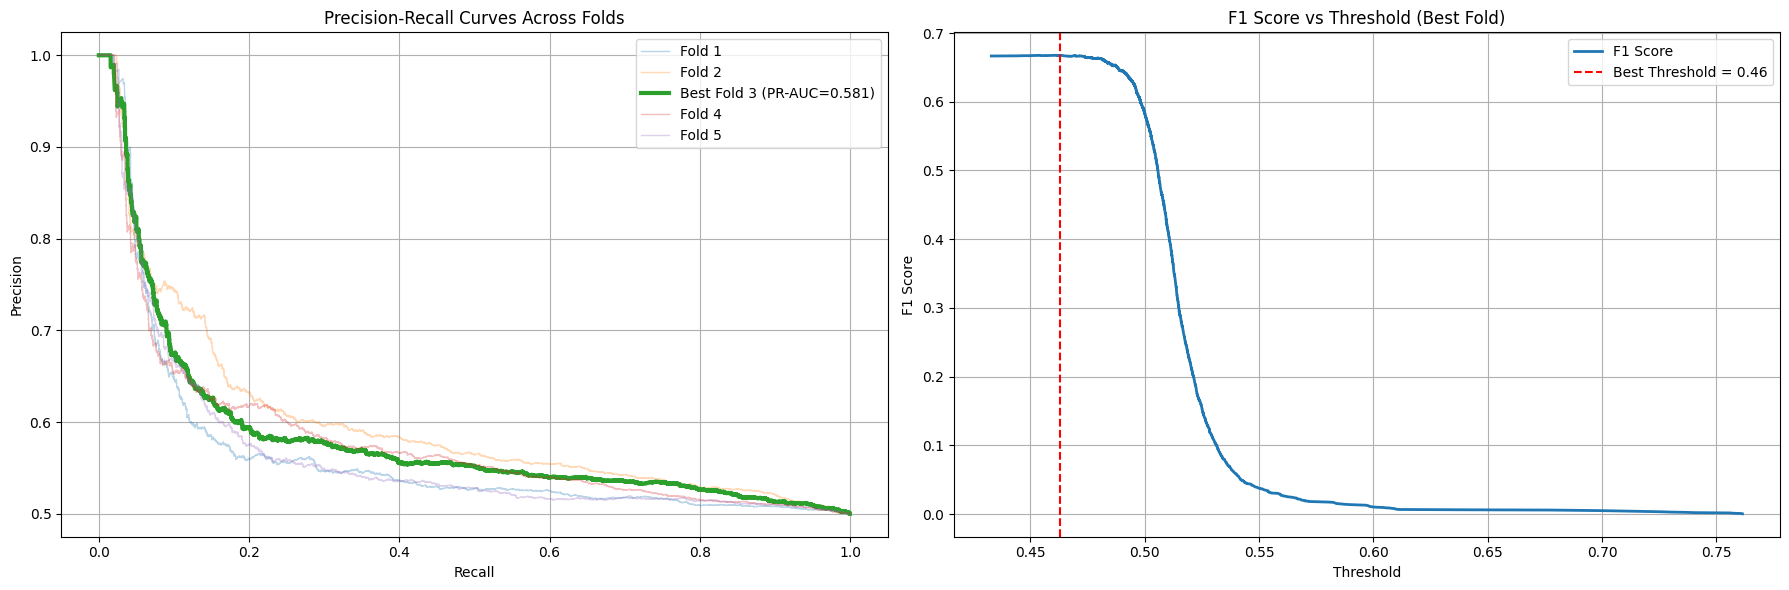

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.571
PR-AUC: 0.587
Best threshold: 0.46
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.001, optimizer=sgd, activation=leaky_relu


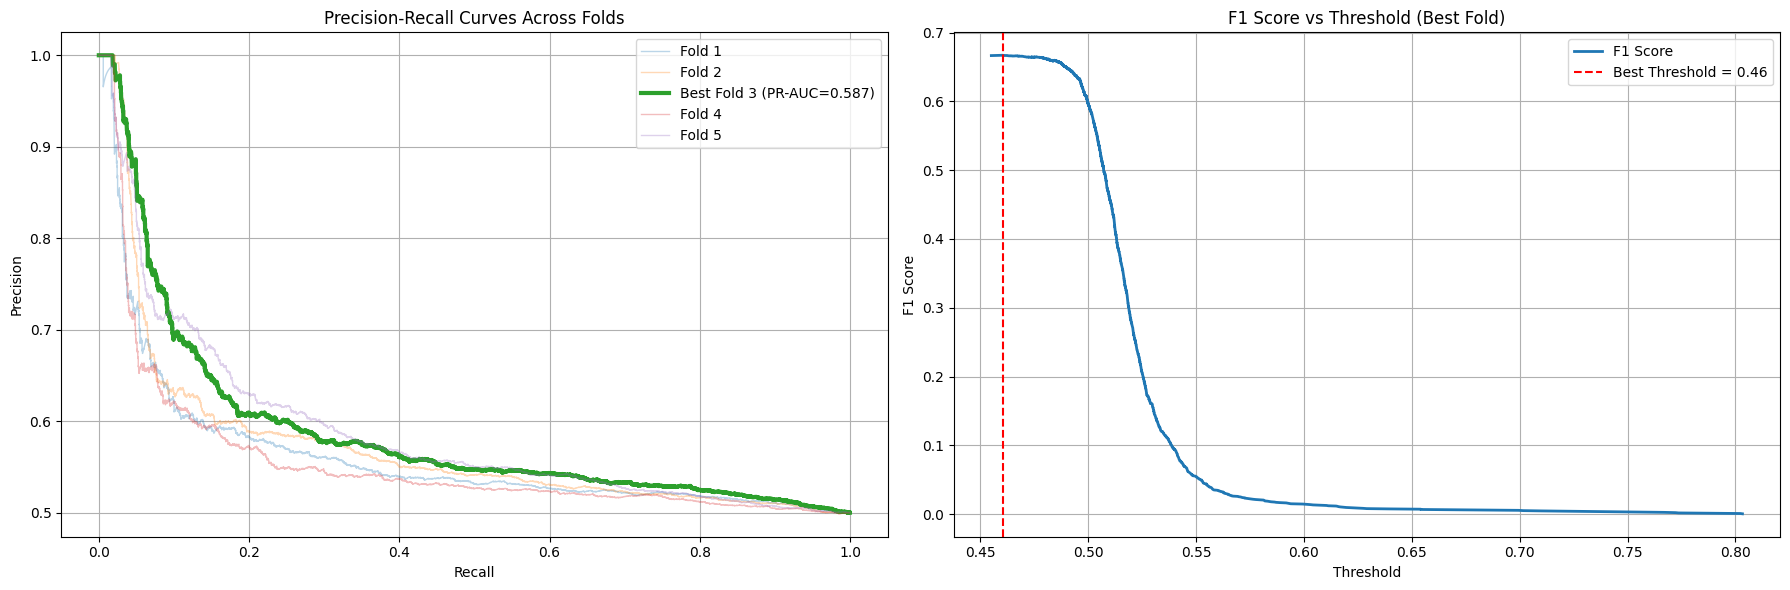

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.707
ROC-AUC: 0.749
PR-AUC: 0.773
Best threshold: 0.37
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.0005, optimizer=adam, activation=relu


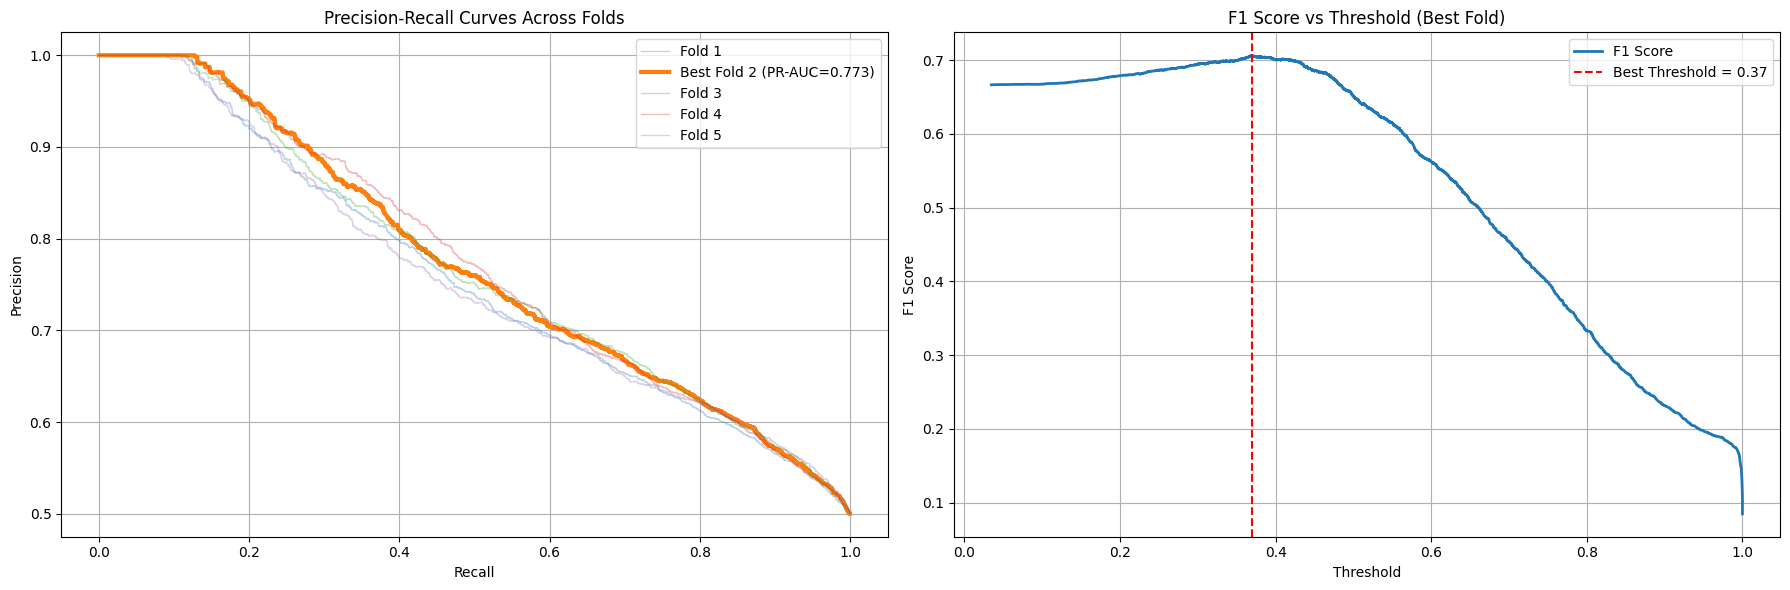

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.710
ROC-AUC: 0.746
PR-AUC: 0.766
Best threshold: 0.34
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.0005, optimizer=adam, activation=leaky_relu


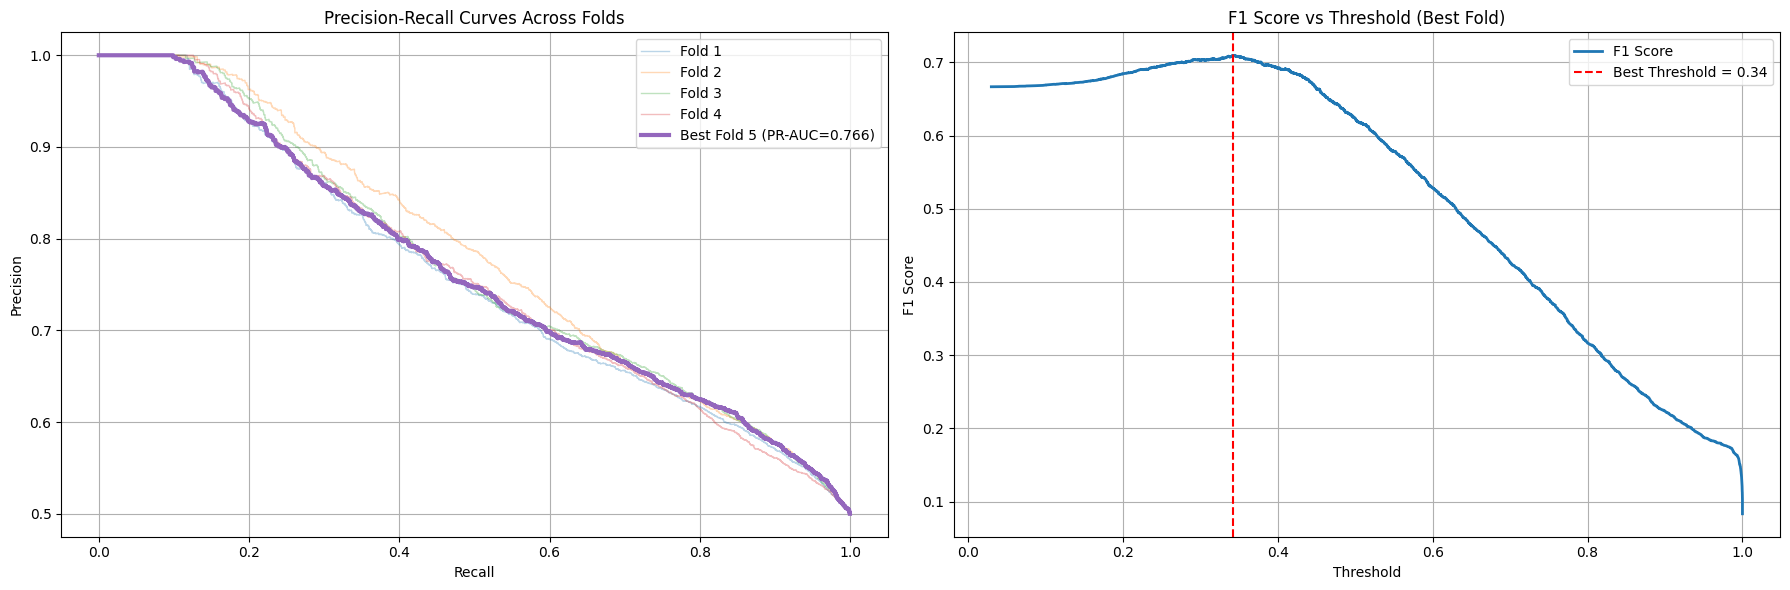

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.553
PR-AUC: 0.573
Best threshold: 0.47
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.0005, optimizer=sgd, activation=relu


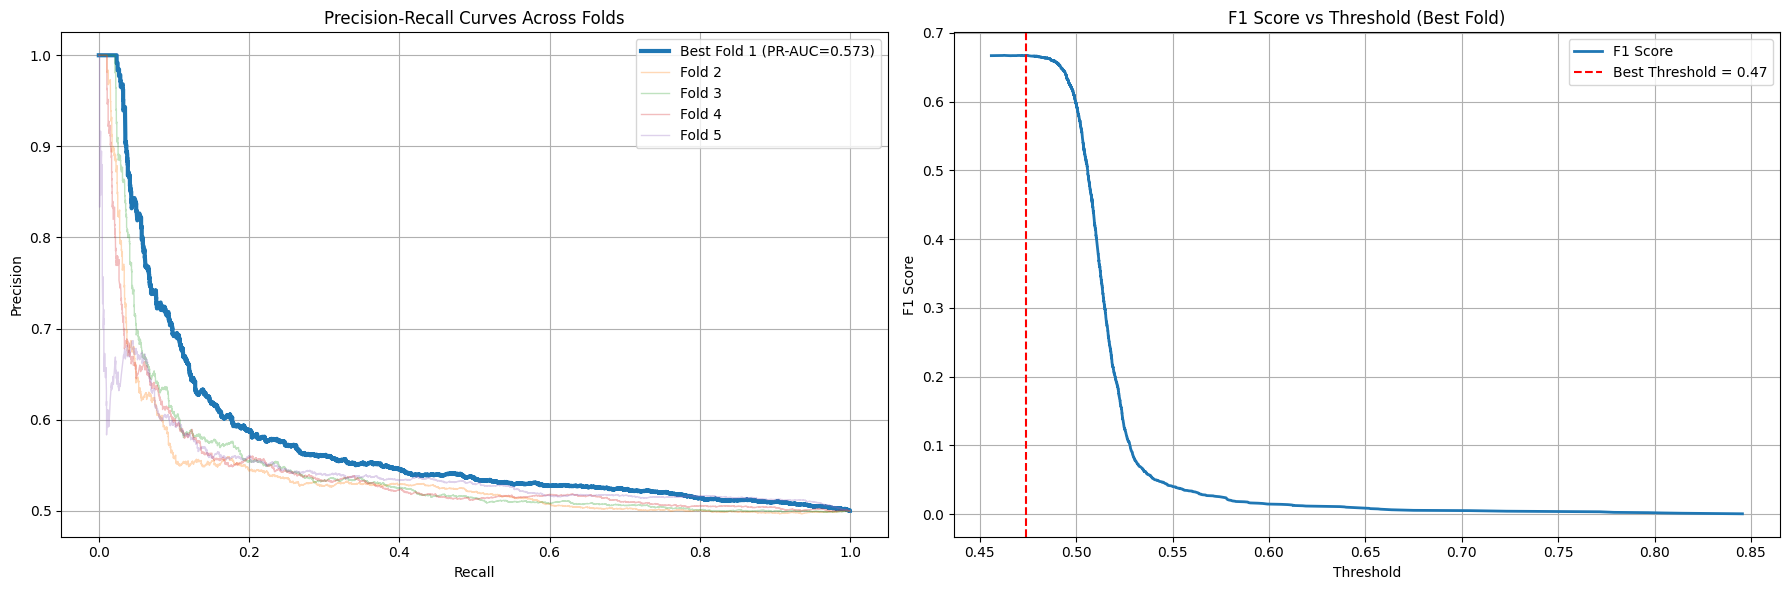

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.669
ROC-AUC: 0.570
PR-AUC: 0.579
Best threshold: 0.49
Hyperparameters: hidden_dims=[256, 128], dropout=0.2, lr=0.0005, optimizer=sgd, activation=leaky_relu


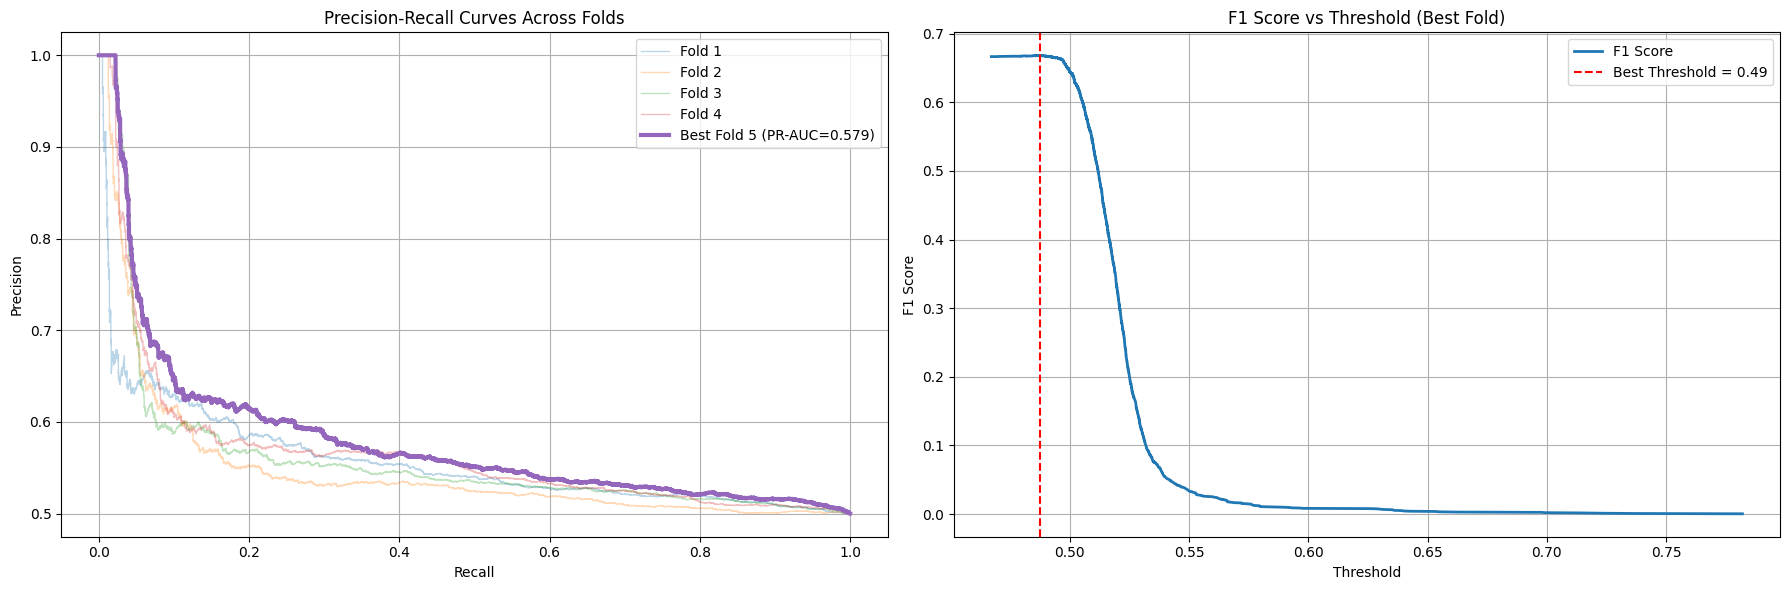

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.706
ROC-AUC: 0.750
PR-AUC: 0.772
Best threshold: 0.35
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.001, optimizer=adam, activation=relu


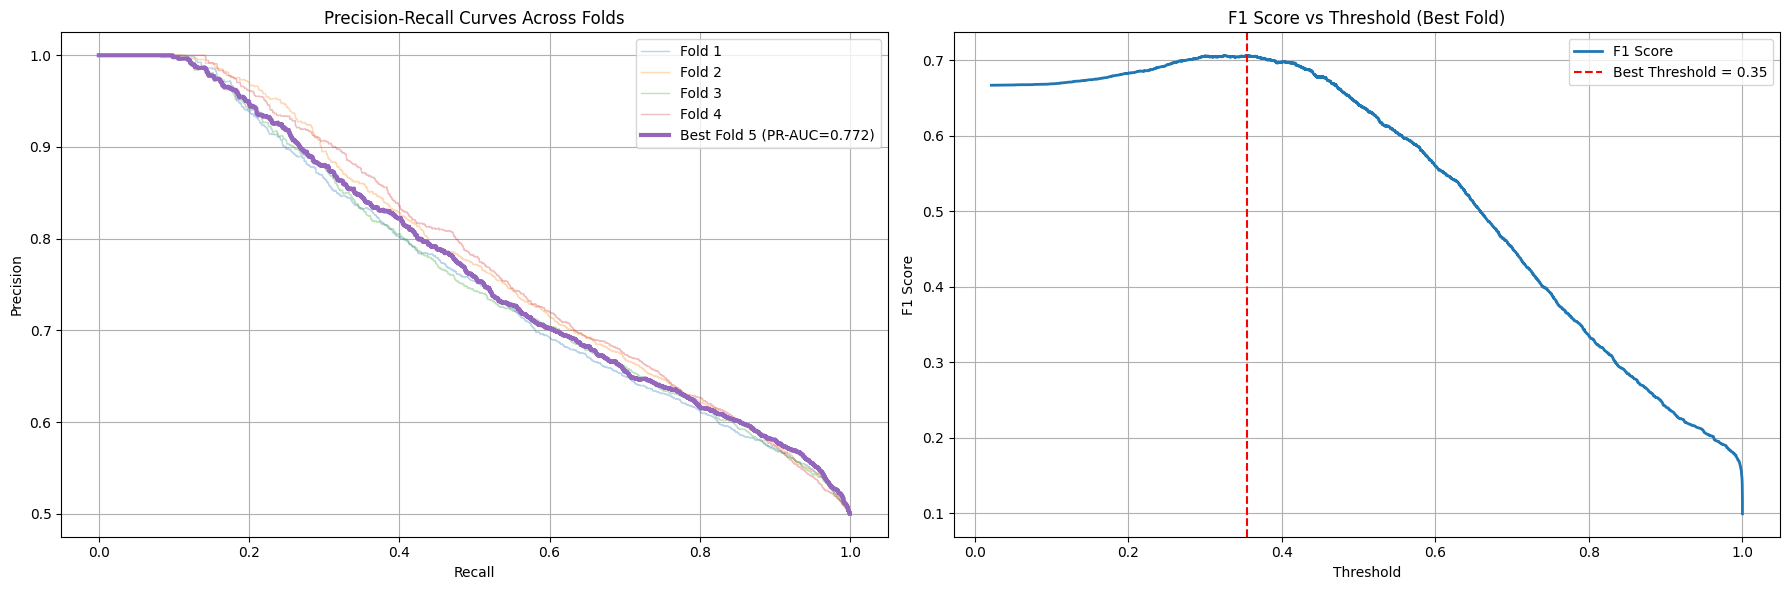

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.708
ROC-AUC: 0.753
PR-AUC: 0.778
Best threshold: 0.32
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.001, optimizer=adam, activation=leaky_relu


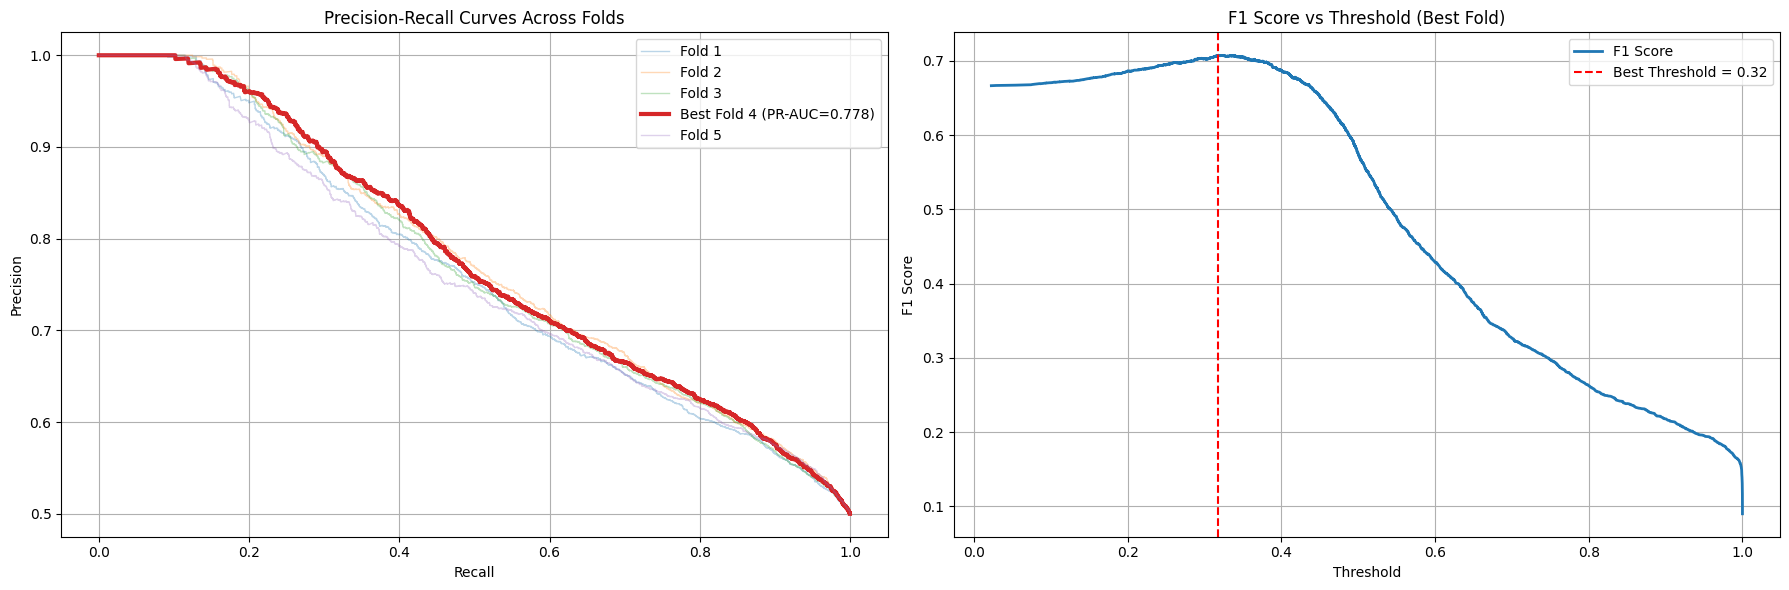

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.670
ROC-AUC: 0.612
PR-AUC: 0.611
Best threshold: 0.48
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.001, optimizer=sgd, activation=relu


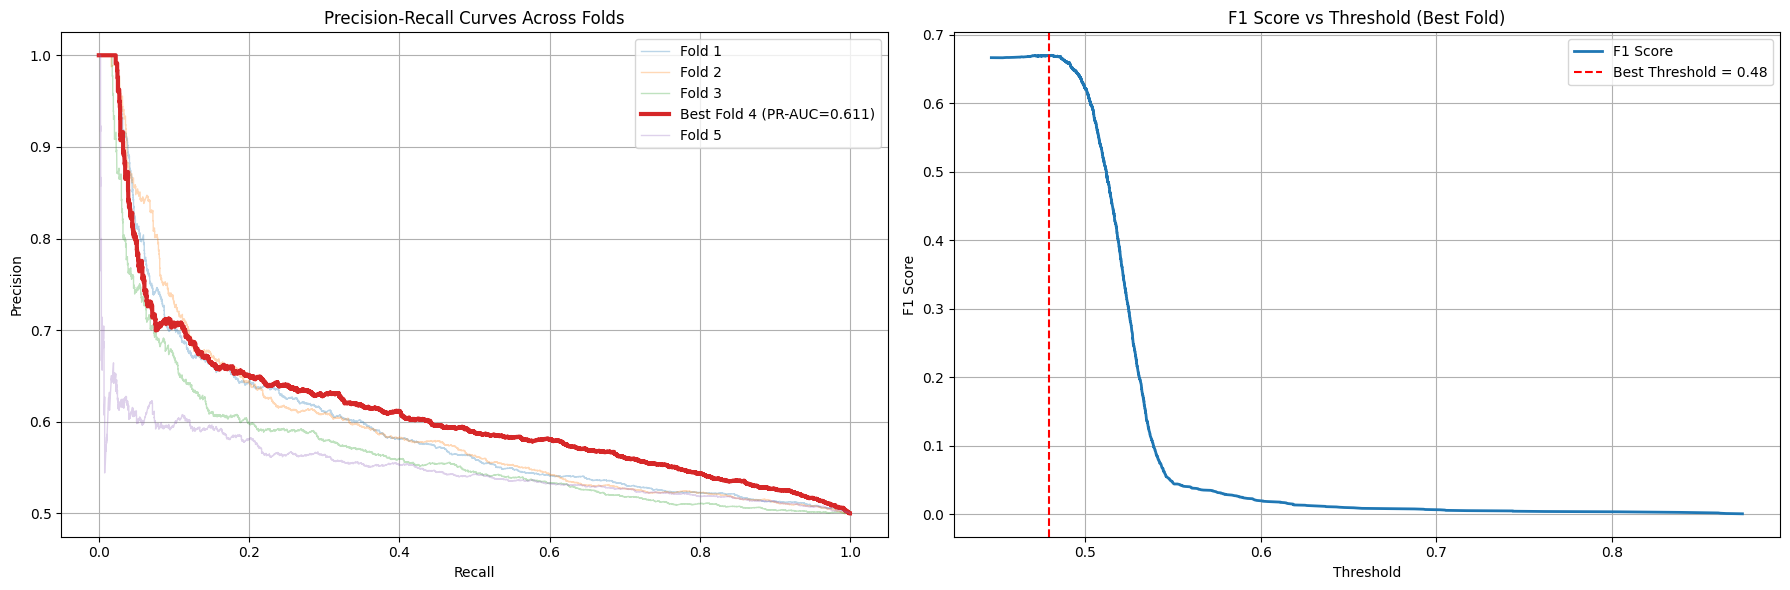

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.668
ROC-AUC: 0.558
PR-AUC: 0.571
Best threshold: 0.48
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.001, optimizer=sgd, activation=leaky_relu


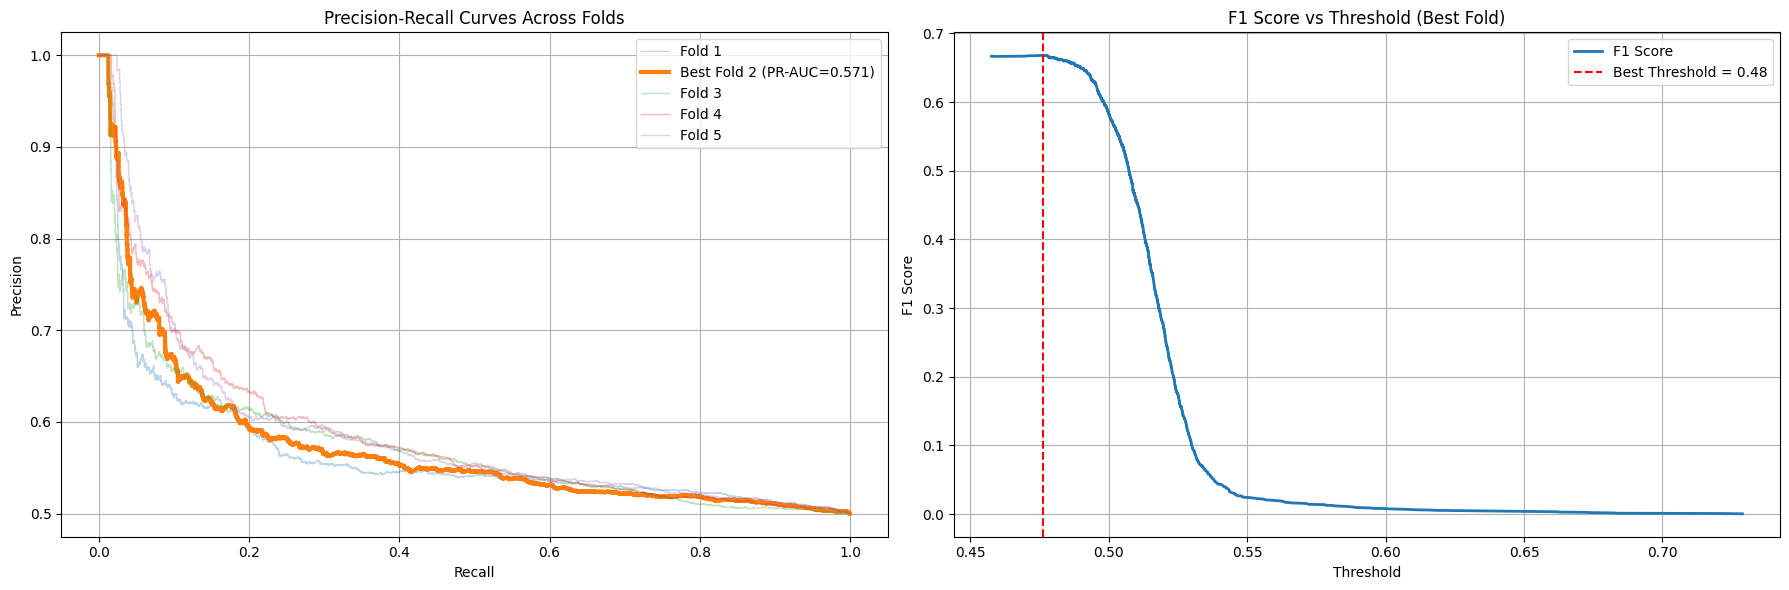

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.707
ROC-AUC: 0.748
PR-AUC: 0.770
Best threshold: 0.35
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.0005, optimizer=adam, activation=relu


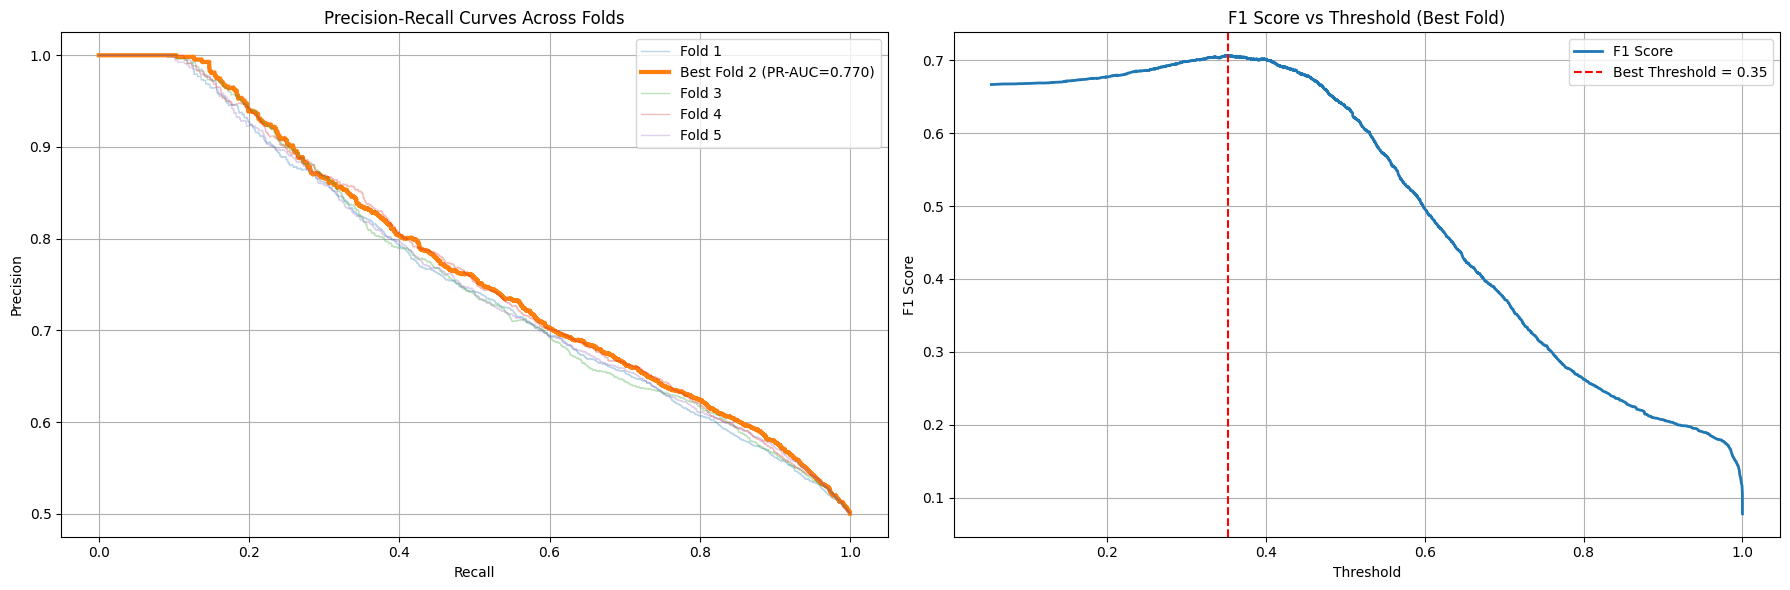

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.704
ROC-AUC: 0.746
PR-AUC: 0.771
Best threshold: 0.40
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.0005, optimizer=adam, activation=leaky_relu


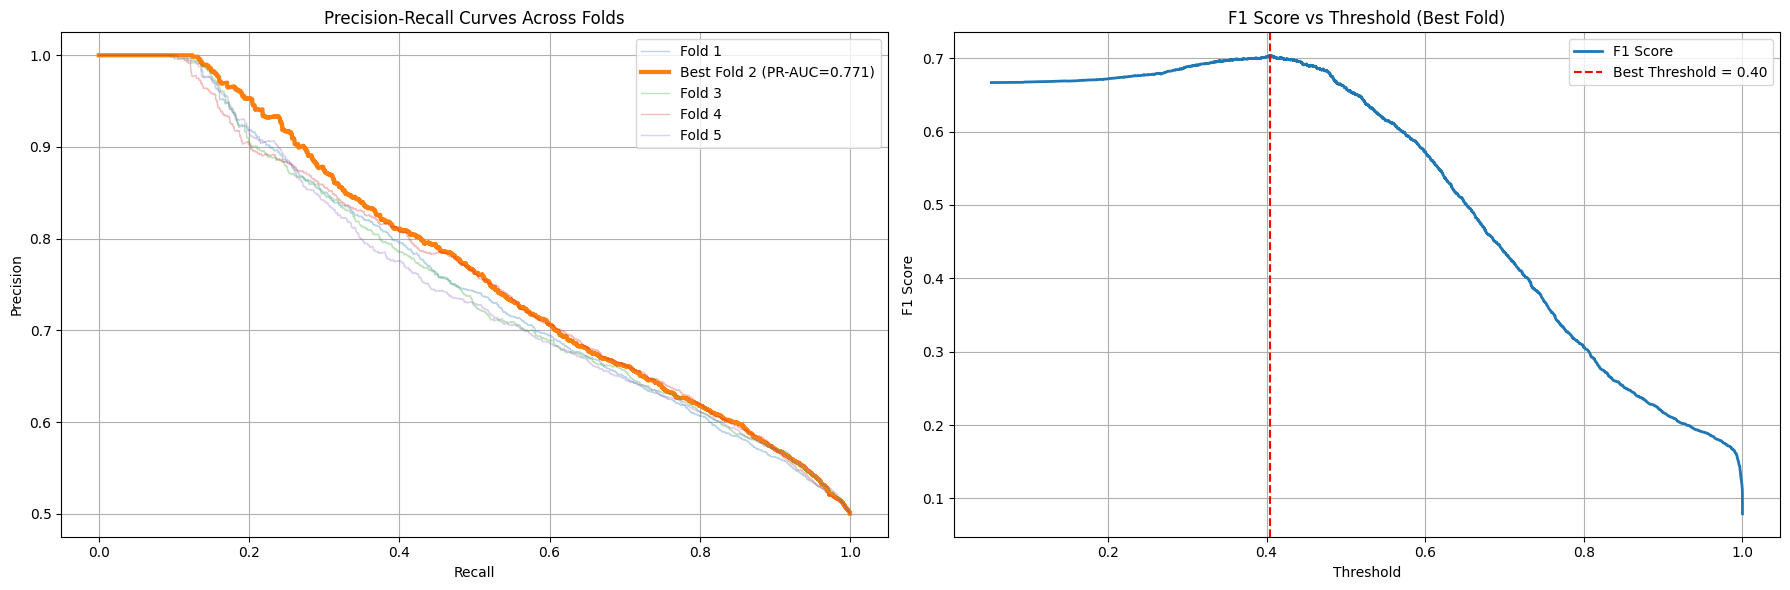

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.667
ROC-AUC: 0.526
PR-AUC: 0.545
Best threshold: 0.47
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.0005, optimizer=sgd, activation=relu


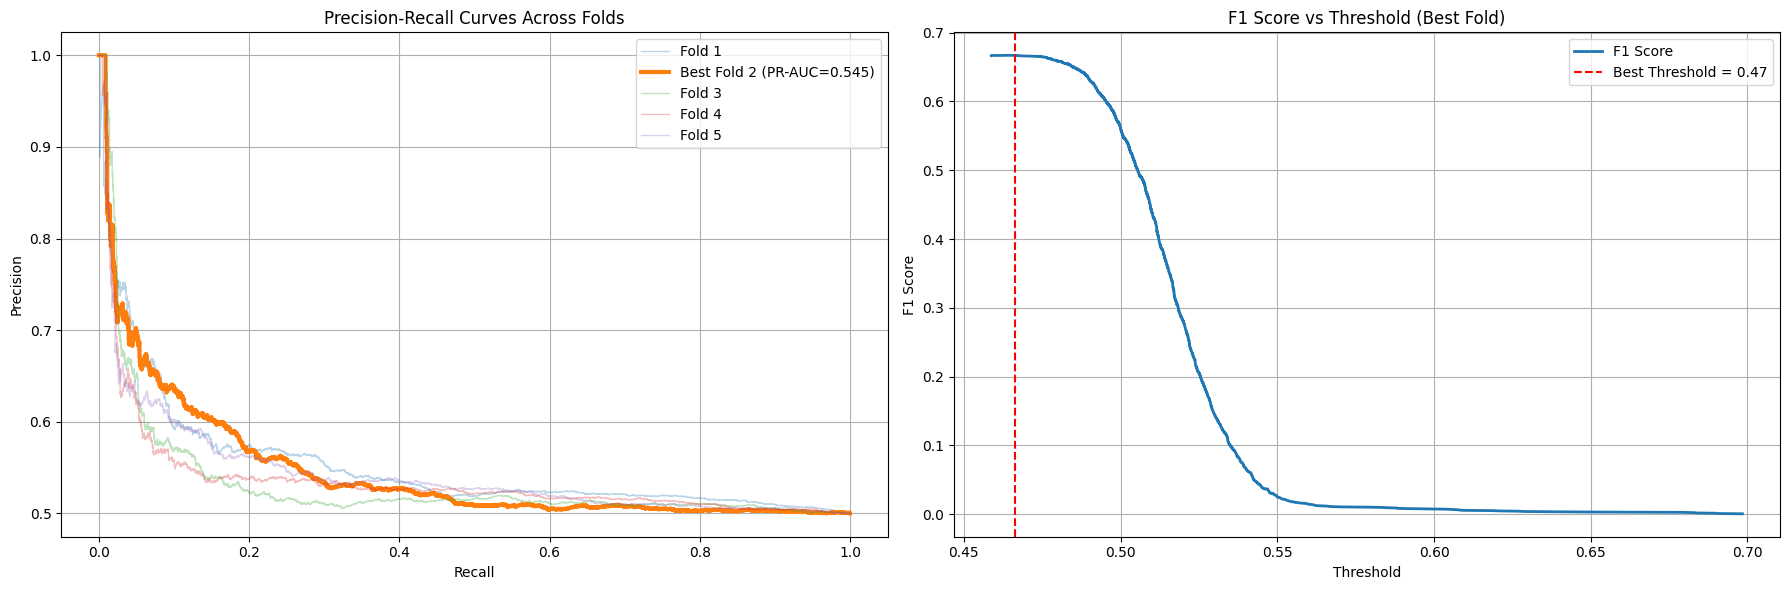

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
=== Best Model Metrics ===
F1 score at best threshold: 0.668
ROC-AUC: 0.540
PR-AUC: 0.528
Best threshold: 0.47
Hyperparameters: hidden_dims=[256, 128], dropout=0.3, lr=0.0005, optimizer=sgd, activation=leaky_relu


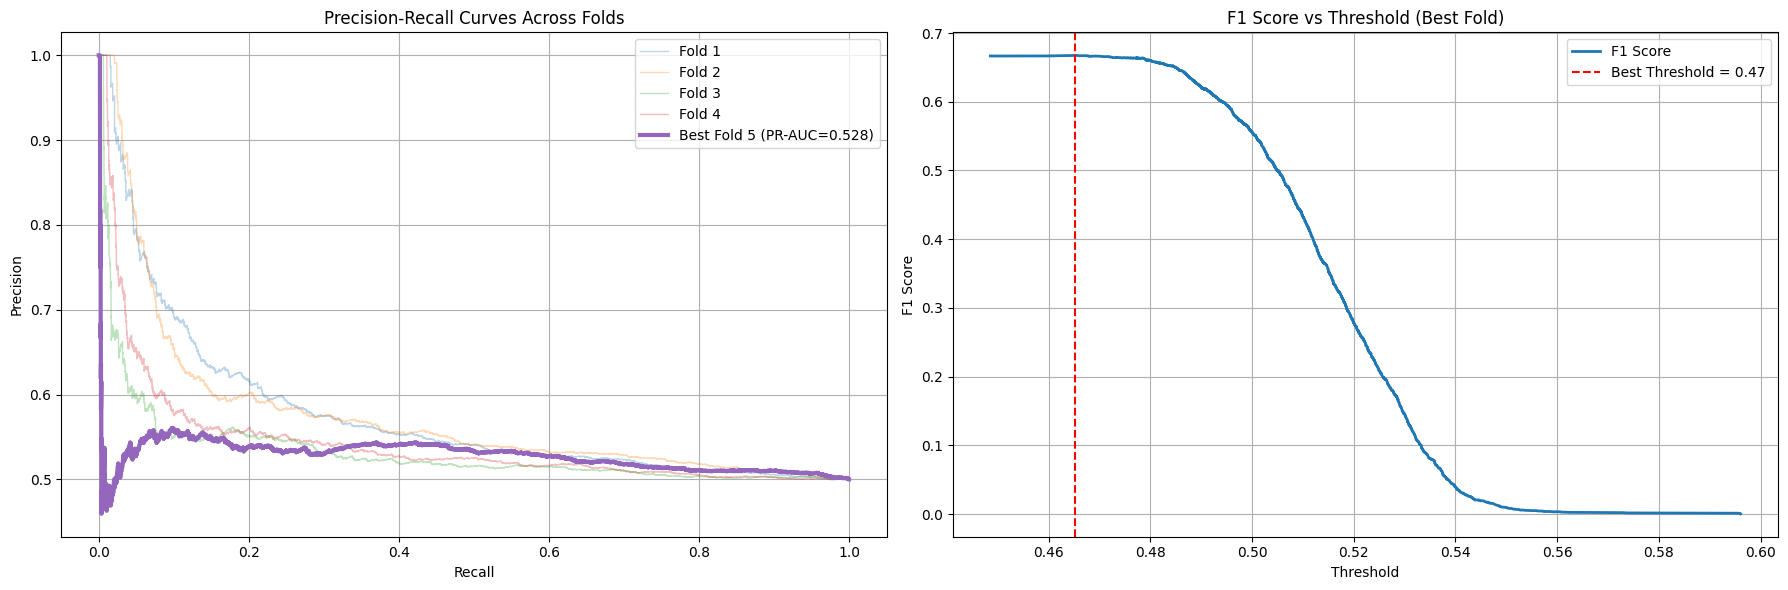

{'pr_auc': 0.7685996635214767, 'precision_vals': array([0.5       , 0.50010502, 0.50015755, ..., 1.        , 1.        ,
       1.        ], shape=(6885,)), 'recall_vals': array([1.        , 1.        , 1.        , ..., 0.05438891, 0.05375892,
       0.        ], shape=(6885,)), 'thresholds': array([0.02314942, 0.05700092, 0.06079295, ..., 0.99999976, 0.9999999 ,
       1.        ], shape=(6884,), dtype=float32), 'f1': 0.7046536886957975, 'roc_auc': 0.7464728246384253, 'best_threshold': np.float32(0.37340742), 'f1_at_threshold': np.float64(0.7046930235218921)}
Best hyperparameters: ([256, 128], 0.2, 0.001, 'adam', 'leaky_relu')
Best mean f1: 0.7156918743175698


In [ ]:
all_cols = X_train_smote_std_cat.columns.tolist()
categorical_encoded_features = [c for c in all_cols if ("encoded" in c) or ("flag" in c)]
numeric_features = [c for c in all_cols if c not in categorical_encoded_features]
X_num = X_train_smote_std_cat[numeric_features]
X_cat = X_train_smote_std_cat[categorical_encoded_features] 
cat_cardinalities = [X_train_smote_std_cat[c].nunique() for c in categorical_encoded_features]
emb_dims = [min(50, (c+1)//2) for c in cat_cardinalities]

param_grid = {
    "hidden_dims": [[128,64], [256,128]],
    "dropout": [0.2, 0.3],
    "lr": [1e-3, 5e-4],
    "optimizer_name": ["adam", "sgd"],
    "activation_name": ["relu", "leaky_relu"]
}


def tune_mlp_embeddings(
    X_num, X_cat, y_train, cat_cardinalities, emb_dims, param_grid,
    n_splits=5, n_epochs=5
):
    
    best_metric = 0
    best_params = None
    best_model = None
    all_results = []

    all_combinations = list(product(
        param_grid["hidden_dims"],
        param_grid["dropout"],
        param_grid["lr"],
        param_grid["optimizer_name"],
        param_grid["activation_name"]
    ))

    print(f"Total hyperparam combinations to evaluate: {len(all_combinations)}")

    for i, comb in enumerate(all_combinations, start=1):
        hidden_dims, dropout, lr, optimizer_name, activation_name = comb
        print(f"\n[{i}/{len(all_combinations)}] Testing combination: "
              f"hidden_dims={hidden_dims}, dropout={dropout}, lr={lr}, "
              f"optimizer={optimizer_name}, activation={activation_name}")

        model, best_metrics, fold_metrics = train_mlp_cv_embeddings(
            X_num, X_cat, y_train, cat_cardinalities, emb_dims,
            hidden_dims=hidden_dims,
            dropout=dropout,
            lr=lr,
            optimizer_name=optimizer_name,
            activation_name=activation_name,
            n_splits=n_splits,
            n_epochs=n_epochs
        )

        mean_f1 = best_metrics['f1_at_threshold']
        all_results.append({
            "params": comb,
            "metrics": best_metrics,
            "fold_metrics": fold_metrics
        })

        print(f"→ Mean F1@Threshold = {mean_f1:.4f}")

        if mean_f1 > best_metric:
            best_metric = mean_f1
            best_params = comb
            best_model = model
            print("★ New best model found!")

    print("\n Best hyperparameters found:")
    print(f"   Params = {best_params}")
    print(f"   Best mean F1@Threshold = {best_metric:.4f}")

    return best_model, best_params, best_metric, all_results






In [ ]:
def evaluate_mlp_on_test(best_model, X_test, y_test, numeric_features, categorical_features, batch_size=64):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)
    best_model.eval()
    
    # Split test data
    X_num_test = torch.tensor(X_test[numeric_features].values, dtype=torch.float32).to(device)
    X_cat_test = torch.tensor(X_test[categorical_features].values, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Predict
    with torch.no_grad():
        y_test_logits = best_model(X_num_test, X_cat_test)
        y_test_proba = torch.sigmoid(y_test_logits).cpu().numpy()
    
    # Tune threshold for best F1
    best_threshold, best_f1 = tune_threshold(y_test.values, y_test_proba)
    y_test_pred = (y_test_proba > best_threshold).astype(int)
    
    # Compute metrics
    test_metrics = {
        "accuracy": accuracy_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "roc_auc": roc_auc_score(y_test, y_test_proba),
        "best_threshold": best_threshold,
        "f1_at_threshold": best_f1
    }
    
    print(f"Test Results → Accuracy={test_metrics['accuracy']:.3f}, "
          f"F1={test_metrics['f1']:.3f}, ROC-AUC={test_metrics['roc_auc']:.3f}, "
          f"Threshold={best_threshold:.2f}, F1@Threshold={best_f1:.3f}")
    
    return test_metrics

all_cols = X_train_smote_std_cat.columns.tolist()
categorical_encoded_features = [c for c in all_cols if ("encoded" in c) or ("flag" in c)]
numeric_features = [c for c in all_cols if c not in categorical_encoded_features]
X_num = X_train_smote_std_cat[numeric_features]
X_cat = X_train_smote_std_cat[categorical_encoded_features] 
cat_cardinalities = [X_train_smote_std_cat[c].nunique() for c in categorical_encoded_features]
emb_dims = [min(50, (c+1)//2) for c in cat_cardinalities]
test_metrics = evaluate_mlp_on_test(best_model, X_test_std_cat, y_test, numeric_features, categorical_encoded_features)

Test Results → Accuracy=0.257, F1=0.229, ROC-AUC=0.549, Threshold=0.24, F1@Threshold=0.229
